# Predictive models for selecting cows for farming

In this project, we are predicting the milk yield (quantity) and milk taste (binary category) to select the best cows for purchase. EcoFarm has 20 cows for sale.

**Our goal**: to recommend cows for purchase whose milk yield will be no less than 6000 kg per year and whose milk will be tasty according to the customer's methodology.

**Data overview**

1. Cow feed parameters:
    * Energy Feed Unit (EFU) - measurement of the nutritional value of cow feed;
    * Raw protein - protein content in feed, in grams;
    * Sugar-Protein Ratio (SPR) - the ratio of sugar to protein in cow feed.
2. Grazing area for cows:
    * Pasture Type - landscape of meadows where the cow grazed.
3. Cow features:
    * id - cow number.
    * Breed - cow breed.
    * Cow age - binary feature (less than 2 years, over 2 years).
    * Sire's name.
    * Sire's breed.
4. Milk characteristics:
    * Fat content - fat content in milk, in percentage.
    * Protein - protein content in milk, in percentage.
    * Milk taste - taste rating according to the customer's criteria.
    * Yield - mass of milk produced by the cow per year, in kilograms.

The dataset with information about the herd contains 634 records. The dataset with information about cows for purchase contains 20 records.

**Research plan**

1. Data loading and overview.
2. Data preprocessing.
3. Exploratory data analysis.
4. Machine learning models for milk yield prediction.
5. Machine learning models for milk taste classification.
6. Research summary.

## 1. Data loading and overview

At this stage, we import the libraries necessary for the research, familiarize ourselves with the data and its format, make superficial conclusions about the data problems that we will need to fix during the preprocessing stage.

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import phik
import math
import scipy.stats as st

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import (StandardScaler, 
                                   OneHotEncoder)

from sklearn.linear_model import (LinearRegression, 
                                  LogisticRegression)

from sklearn.metrics import (root_mean_squared_error,
                             mean_absolute_error,
                             r2_score,
                             accuracy_score,
                             confusion_matrix,
                             recall_score,
                             precision_score)

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from IPython.display import display

# Setting for clear graphs on high-resolution screens
%config InlineBackend.figure_format = 'retina'

RANDOM_STATE = 42

In [2]:
# Load data sets
short_path = 'datasets/'
full_path = 'https://code.s3.yandex.net/datasets/'

try:
    data = pd.read_csv(short_path + 'ferma_main.csv', sep=';', decimal=',', index_col='id')
    data_sires = pd.read_csv(short_path + 'ferma_dad.csv', sep=';', decimal=',', index_col='id')
    data_purchase = pd.read_csv(short_path + 'cow_buy.csv', sep=';', decimal=',')
except:
    data = pd.read_csv(full_path + 'ferma_main.csv', sep=';', decimal=',', index_col='id')
    data_sires = pd.read_csv(full_path + 'ferma_dad.csv', sep=';', decimal=',', index_col='id')
    data_purchase = pd.read_csv(full_path + 'cow_buy.csv', sep=';', decimal=',')

In [3]:
# Show herd info
display(data.head())
data.info()

Удой, кг  ЭКЕ (Энергетическая кормовая единица)  Сырой протеин, г  \
id                                                                      
1       5863                                   14.2              1743   
2       5529                                   12.8              2138   
3       5810                                   14.0              1854   
4       5895                                   12.4              2012   
5       5302                                   12.8              1675   

    СПО (Сахаро-протеиновое соотношение)           Порода Тип пастбища  \
id                                                                       
1                                  0.890   Вис Бик Айдиал    Равнинное   
2                                  0.890   Вис Бик Айдиал    Равнинные   
3                                  0.885  РефлешнСоверинг    Холмистое   
4                                  0.885  РефлешнСоверинг    Холмистое   
5                                  0.885   Вис Бик Айдиал    Равнинные   

   порода папы_быка  Жирность,%  Белок,% Вкус молока      Возраст  
id                                                                 
1            Айдиал        3.58    3.076      вкусно  более_2_лет  
2           Соверин        3.54    3.079      вкусно  менее_2_лет  
3           Соверин        3.59    3.074   не вкусно  более_2_лет  
4            Айдиал        3.40    3.075   не вкусно  более_2_лет  
5           Соверин        3.73    3.073      вкусно  менее_2_лет

<class 'pandas.core.frame.DataFrame'>
Index: 634 entries, 1 to 627
Data columns (total 11 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   Удой, кг                               634 non-null    int64  
 1   ЭКЕ (Энергетическая кормовая единица)  634 non-null    float64
 2   Сырой протеин, г                       634 non-null    int64  
 3   СПО (Сахаро-протеиновое соотношение)   634 non-null    float64
 4   Порода                                 634 non-null    object 
 5   Тип пастбища                           634 non-null    object 
 6   порода папы_быка                       634 non-null    object 
 7   Жирность,%                             634 non-null    float64
 8   Белок,%                                634 non-null    float64
 9   Вкус молока                            634 non-null    object 
 10  Возраст                                634 non-null    object 
dtypes: float64(

In [4]:
# Show sires info
display(data_sires.head())
data_sires.info()

Имя Папы
id          
1     Буйный
2   Соловчик
3      Барин
4     Буйный
5      Барин

<class 'pandas.core.frame.DataFrame'>
Index: 629 entries, 1 to 629
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Имя Папы  629 non-null    object
dtypes: object(1)
memory usage: 9.8+ KB


In [5]:
# Show cows for purchase info
display(data_purchase.head())
data_purchase.info()

Порода Тип пастбища порода папы_быка  Имя_папы  \
0   Вис Бик Айдиал    холмистое           Айдиал  Геркулес   
1   Вис Бик Айдиал    равнинное          Соверин    Буйный   
2  РефлешнСоверинг    равнинное          Соверин     Барин   
3  РефлешнСоверинг    холмистое           Айдиал    Буйный   
4  РефлешнСоверинг    равнинное           Айдиал    Буйный   

   Текущая_жирность,%  Текущий_уровень_белок,%      Возраст  
0                3.58                    3.076  более_2_лет  
1                3.54                    3.081  менее_2_лет  
2                3.59                    3.074  более_2_лет  
3                3.40                    3.061  более_2_лет  
4                3.64                    3.074  более_2_лет

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Порода                   20 non-null     object 
 1   Тип пастбища             20 non-null     object 
 2   порода папы_быка         20 non-null     object 
 3   Имя_папы                 20 non-null     object 
 4   Текущая_жирность,%       20 non-null     float64
 5   Текущий_уровень_белок,%  20 non-null     float64
 6   Возраст                  20 non-null     object 
dtypes: float64(2), object(5)
memory usage: 1.2+ KB


### Summary

- Three datasets were received: one with information about the herd (634 records), one with information about the sires of the herd (629 records), and one about cows from EcoFarm available for purchase (20 records).
- None of the datasets have explicit missing values.
- The different numbers of records in the datasets with information about the herd and the sires may indicate the presence of duplicates.
- The datasets with information about the herd and the sires can be merged into one based on the cow ID.
- Column names are in Cyrillic, contain spaces, and are in different cases, which will worsen code readability and create problems when working with the data.
- Binary features are represented as strings; they can be replaced with logical values.
- Implicit duplicates may exist in the features: breed, sire's breed, and pasture type.

##  2. Data preprocessing

At this stage, we clean the data, make it more suitable for research by addressing issues such as:
* incorrect column names;
* duplicates (explicit and implicit);
* empty cells;
* incorrect data format in cells;
* incorrect data.

In [6]:
# Rename the columns

# ЭКЕ (Энергетическая кормовая единица) --> energy_feed_unit
# Сырой протеин, г --> crude_protein
# СПО (Сахаро-протеиновое соотношение) --> sugar_protein_ratio
# Тип пастбища --> pasture_type
# Порода --> breed
# Возраст --> age
# Имя Папы --> sire_name
# порода папы_быка --> sire_breed
# Жирность,% --> milk_fat
# Белок,% --> milk_protein
# Вкус молока --> milk_taste
# Удой, кг --> milk_yield

data.columns = ['milk_yield', 'energy_feed_unit',
                'crude_protein', 'sugar_protein_ratio', 
                'breed', 'pasture_type', 'sire_breed',
                'milk_fat', 'milk_protein', 'milk_taste','age']

data_sires.columns = ['sire_name']

data_purchase.columns = ['breed',
                         'pasture_type',
                         'sire_breed',
                         'sire_name',
                         'milk_fat',
                         'milk_protein',
                         'age']

Our `data_sires` dataset contains only 5 entries and doesn't require preprocessing, we will focus on `data` and `data_purchase`.

There are no missing values in the datasets so we can start looking closely at the features in them.

In [7]:
print(data['age'].value_counts(dropna=False))
print()
print(data_purchase['age'].value_counts(dropna=False))

age
более_2_лет    524
менее_2_лет    110
Name: count, dtype: int64

age
более_2_лет    15
менее_2_лет     5
Name: count, dtype: int64


Column `age` contains two categories and has no implicit duplicates. Let's convert in to `category` type.

In [8]:
# Translate
data['age'] = data['age'].replace('более_2_лет','old', regex=True)
data['age'] = data['age'].replace('менее_2_лет','young', regex=True)
data_purchase['age'] = data_purchase['age'].replace('более_2_лет','old', regex=True)
data_purchase['age'] = data_purchase['age'].replace('менее_2_лет','young', regex=True)

# Convert 'age' to category
data['age'] = data['age'].astype('category')
data_purchase['age'] = data_purchase['age'].astype('category')

Let's check one of our target features `milk_taste`.

In [9]:
print(data['milk_taste'].value_counts(dropna=False))

milk_taste
вкусно       371
не вкусно    263
Name: count, dtype: int64


Target feature contain two categories, we are solving binary classification problem.

In [10]:
# Translate
data['milk_taste'] = data['milk_taste'].replace('не','not',regex=True)
data['milk_taste'] = data['milk_taste'].replace('вкусно','tasty',regex=True)


# Convert 'milk_taste' to category
data['milk_taste'] = data['milk_taste'].astype('category')

In [11]:
print(data['pasture_type'].value_counts(dropna=False))
print()
print(data_purchase['pasture_type'].value_counts(dropna=False))

pasture_type
Холмистое    356
Равнинное    253
Равнинные     25
Name: count, dtype: int64

pasture_type
равнинное    11
холмистое     9
Name: count, dtype: int64


There are implicit duplicates in the column `pasture_type`, let's fix this.

In [12]:
# Remove implicit duplicates in 'pasture_type', convert to category
data['pasture_type'] = data['pasture_type'].str.lower().replace(['равнинные','равнинное'], 'plain', regex=True)
data['pasture_type'] = data['pasture_type'].str.lower().replace('холмистое', 'hill', regex=True)
data_purchase['pasture_type'] = data_purchase['pasture_type'].replace('равнинное', 'plain', regex=True)
data_purchase['pasture_type'] = data_purchase['pasture_type'].replace('холмистое', 'hill', regex=True)

data['pasture_type'] = data['pasture_type'].astype('category')
data_purchase['pasture_type'] = data_purchase['pasture_type'].astype('category')

In [13]:
# Check 'breed' и 'father_breed'
print(data['breed'].value_counts(dropna=False))
print()
print(data_purchase['breed'].value_counts(dropna=False))
print()
print(data['sire_breed'].value_counts(dropna=False))
print()
print(data_purchase['sire_breed'].value_counts(dropna=False))

breed
Вис Бик Айдиал     373
РефлешнСоверинг    261
Name: count, dtype: int64

breed
РефлешнСоверинг    11
Вис Бик Айдиал      9
Name: count, dtype: int64

sire_breed
Соверин    316
Айдиал     240
Айдиалл     78
Name: count, dtype: int64

sire_breed
Соверин    12
Айдиал      8
Name: count, dtype: int64


There are also implicit duplicates in breeds. Let's fix this.

In [14]:
# Remove implicit duplicates in breeds
# Function for breed replacement
def breed_replace(breed):
    if 'овери' in breed:
        return 'Sovereign'
    elif 'йд' in breed:
        return 'Ideal'
    else:
        return 'error'

In [15]:
# Replace breeds
data['breed'] = data['breed'].apply(breed_replace)
data['sire_breed'] = data['sire_breed'].apply(breed_replace)
data_purchase['breed'] = data_purchase['breed'].apply(breed_replace)
data_purchase['sire_breed'] = data_purchase['sire_breed'].apply(breed_replace)

# Check the result
print(data['breed'].value_counts(dropna=False))
print()
print(data_purchase['breed'].value_counts(dropna=False))
print()
print(data['sire_breed'].value_counts(dropna=False))
print()
print(data_purchase['sire_breed'].value_counts(dropna=False))

breed
Ideal        373
Sovereign    261
Name: count, dtype: int64

breed
Sovereign    11
Ideal         9
Name: count, dtype: int64

sire_breed
Ideal        318
Sovereign    316
Name: count, dtype: int64

sire_breed
Sovereign    12
Ideal         8
Name: count, dtype: int64


In [16]:
# Convert breed и sire_breed к типу category
data['breed'] = data['breed'].astype('category')
data['sire_breed'] = data['sire_breed'].astype('category')
data_purchase['breed'] = data_purchase['breed'].astype('category')
data_purchase['sire_breed'] = data_purchase['sire_breed'].astype('category')

In [17]:
# Check explicit duplicates
print('Duplicates in data:',data.duplicated().sum())
print('Duplicates in data_purchase:',data_purchase.duplicated().sum())

Duplicates in data: 5
Duplicates in data_purchase: 4


We have 634 entries in `data` and 20 entries in `data_purchase`. We need to check if it's possible that different cows have identical parameters.

In [18]:
# Check duplicates based on 'breed','pasture_type','sire_breed','milk_fat','milk_protein','age'
data.duplicated(['breed','pasture_type','sire_breed','milk_fat','milk_protein','age']).sum()

169

As we can see it's very possible that different cows have identical parameters. We will remove duplicates in `data` as we don't need duplicated entries in the training dataset, but we will leave all the duplicates in `data_purchase` so we don't reduce the number of cows that we can recomment for purchase.

In [19]:
# Delete explicit duplicates in data_cows and reset index
data = data.drop_duplicates().reset_index(drop=True)

In [20]:
# Convert sire_name to category
data_sires['sire_name'] = data_sires['sire_name'].astype('category')

In [21]:
# Set names for datasets
data.name = 'cows of our herd'
data_purchase.name = 'EcoFarm cows'

In [22]:
# Show the info
display(data.head())
data.info()

milk_yield  energy_feed_unit  crude_protein  sugar_protein_ratio  \
0        5863              14.2           1743                0.890   
1        5529              12.8           2138                0.890   
2        5810              14.0           1854                0.885   
3        5895              12.4           2012                0.885   
4        5302              12.8           1675                0.885   

       breed pasture_type sire_breed  milk_fat  milk_protein milk_taste    age  
0      Ideal        plain      Ideal      3.58         3.076      tasty    old  
1      Ideal        plain  Sovereign      3.54         3.079      tasty  young  
2  Sovereign         hill  Sovereign      3.59         3.074  not tasty    old  
3  Sovereign         hill      Ideal      3.40         3.075  not tasty    old  
4      Ideal        plain  Sovereign      3.73         3.073      tasty  young

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 629 entries, 0 to 628
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   milk_yield           629 non-null    int64   
 1   energy_feed_unit     629 non-null    float64 
 2   crude_protein        629 non-null    int64   
 3   sugar_protein_ratio  629 non-null    float64 
 4   breed                629 non-null    category
 5   pasture_type         629 non-null    category
 6   sire_breed           629 non-null    category
 7   milk_fat             629 non-null    float64 
 8   milk_protein         629 non-null    float64 
 9   milk_taste           629 non-null    category
 10  age                  629 non-null    category
dtypes: category(5), float64(4), int64(2)
memory usage: 33.3 KB


In [23]:
display(data_sires.head())
data_sires.info()

sire_name
id          
1     Буйный
2   Соловчик
3      Барин
4     Буйный
5      Барин

<class 'pandas.core.frame.DataFrame'>
Index: 629 entries, 1 to 629
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   sire_name  629 non-null    category
dtypes: category(1)
memory usage: 5.7 KB


In [24]:
display(data_purchase.head())
data_purchase.info()

breed pasture_type sire_breed sire_name  milk_fat  milk_protein    age
0      Ideal         hill      Ideal  Геркулес      3.58         3.076    old
1      Ideal        plain  Sovereign    Буйный      3.54         3.081  young
2  Sovereign        plain  Sovereign     Барин      3.59         3.074    old
3  Sovereign         hill      Ideal    Буйный      3.40         3.061    old
4  Sovereign        plain      Ideal    Буйный      3.64         3.074    old

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   breed         20 non-null     category
 1   pasture_type  20 non-null     category
 2   sire_breed    20 non-null     category
 3   sire_name     20 non-null     object  
 4   milk_fat      20 non-null     float64 
 5   milk_protein  20 non-null     float64 
 6   age           20 non-null     category
dtypes: category(4), float64(2), object(1)
memory usage: 1.2+ KB


### Summary

- Column names have been standardized to a unified format (English, snake_case), which will not affect the research results but will improve code readability.
- No missing data has been found.
- Columns with binary features such as `age` and `milk_taste` have been converted to the category data type.
- Implicit duplicates in `pasture_type` and `breed` have been removed.
- No implicit duplicates in sire's names have been found.
- Sire's names have been converted to the category data type.
- Explicit duplicates have been found in both datasets.
- Five duplicate rows (0.8%) have been removed from the dataset containing information about the herd.
- Four duplicate rows (20%) in the dataset containing information about cows from "EcoFarm" were not removed, as there are grounds to believe that two different cows may coincide in a combination of parameters (`breed`, `pasture_type`, `sire_breed`, `age`, and milk parameters).

## 3. Exploratory data analysis

At this stage, we will explore the distribution of features, identify and eliminate anomalies in the data. We also will search for relationships between features.

Before we start, we will create functions for diagrams and plots so we don't repeat the same code again and again.

In [25]:
# Function for histograms
def draw_norm_histogram(data, column):
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,5))
    ax.set_title(f'{column} distribution ({data.name})',
                 fontweight='semibold')
    ax.set_xlabel(f'Feature: {column}')
    ax.set_ylabel('Density')
    sns.histplot(data,
                 x=column,
                 stat='density',
                 common_norm=False,
                 ax=ax)
    plt.show()

In [26]:
# Function for piecharts
def draw_piechart(data, column):
    vc = data[column].value_counts()
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,5))
    ax.set_title(f'{column} ratio ({data.name})',
              fontweight='semibold')
    ax.pie(x=vc,
           labels=vc.index,
           autopct='%1.1f%%')
    plt.show()

In [27]:
# Function for scatterplots
def draw_scatterplot(data, column, hue=None):
    num_columns = (data
                   .drop([column],axis=1)
                   .select_dtypes(include='number')
                   .columns.tolist()
                  )
    fig, axes = plt.subplots(nrows=1,
                             ncols=5,
                             sharey=True,
                             figsize = (17,4))
    if hue==None:
        plt.suptitle(f'Relationship between {column} and quntitative features',
                     fontweight='semibold')
    else:
        plt.suptitle(f'Relationship between {column} and quntitative features depending on {hue}',
                     fontweight='semibold')
    for i in range(0,len(num_columns)):
        sns.scatterplot(data=data,
                        x=data[num_columns[i]],
                        y=column,
                        hue=hue, 
                        ax=axes[i])
    plt.show()

### Target feature `milk_yield`

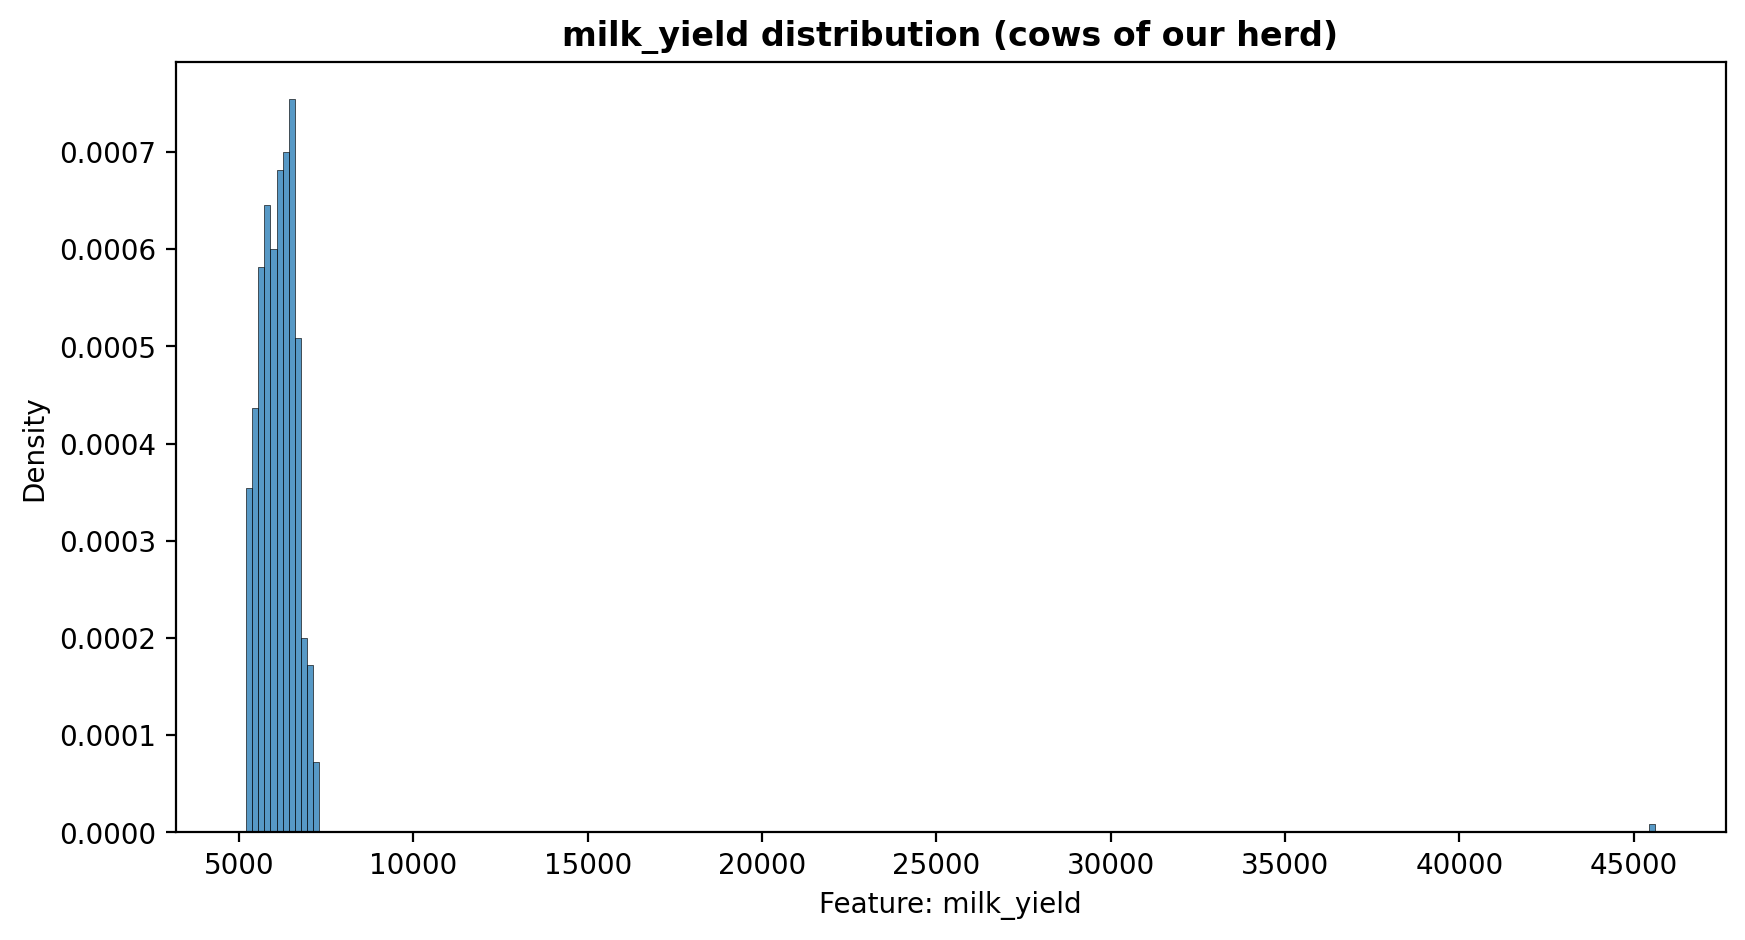

count      629.00
mean      6188.75
std       1644.80
min       5204.00
25%       5751.00
50%       6133.00
75%       6501.00
max      45616.00
Name: milk_yield, dtype: float64

In [28]:
# Initial distribution
draw_norm_histogram(data=data,
                    column='milk_yield')

data['milk_yield'].describe().round(2)

Entries with anomalous `milk_yield` have been detected.

In [29]:
# Delete the anomalies
data = data.loc[data['milk_yield']<8000]
data.name = 'cows of our herd'

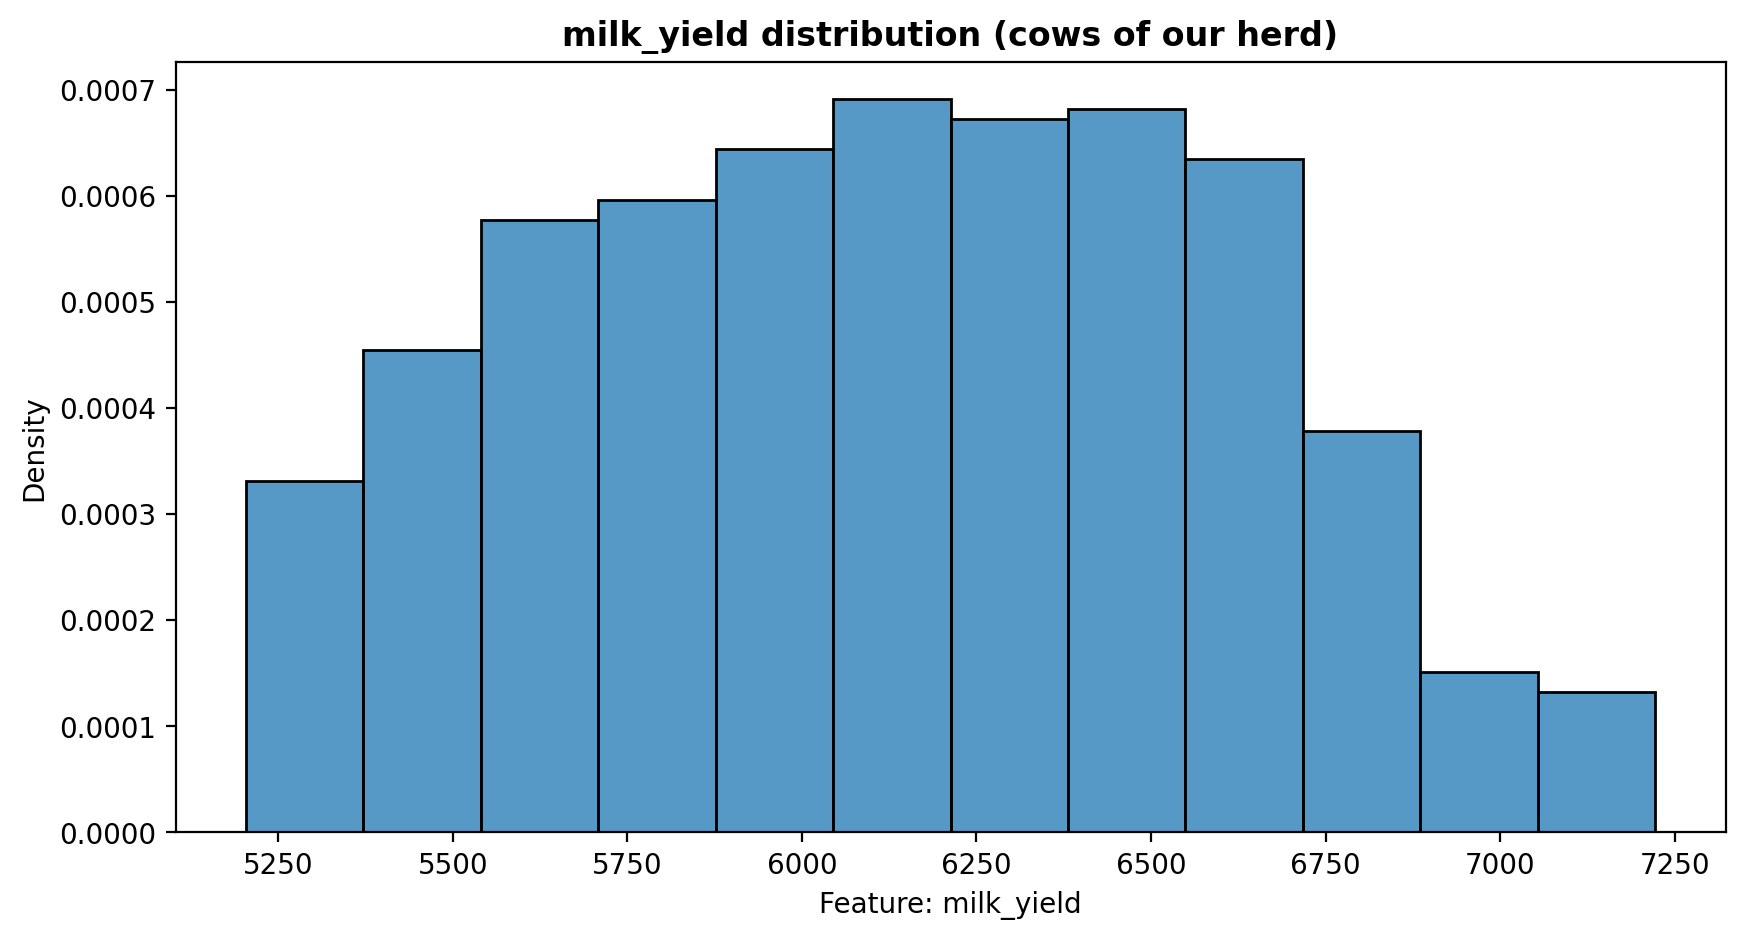

count     628.00
mean     6125.97
std       475.86
min      5204.00
25%      5749.75
50%      6132.50
75%      6501.00
max      7222.00
Name: milk_yield, dtype: float64

In [30]:
# Distribution after deleting the anomalies
draw_norm_histogram(data=data,
                    column='milk_yield')

data['milk_yield'].describe().round(2)

One anomalous row has been removed. The distribution resembles a normal distribution, but the lower bound is almost twice as high as the upper one. This may be explained by the fact that the farm is not interested in keeping cows that produce too little milk. As for the upper yield limit, it is limited only by physiological factors.

### Feature `energy_feed_unit`

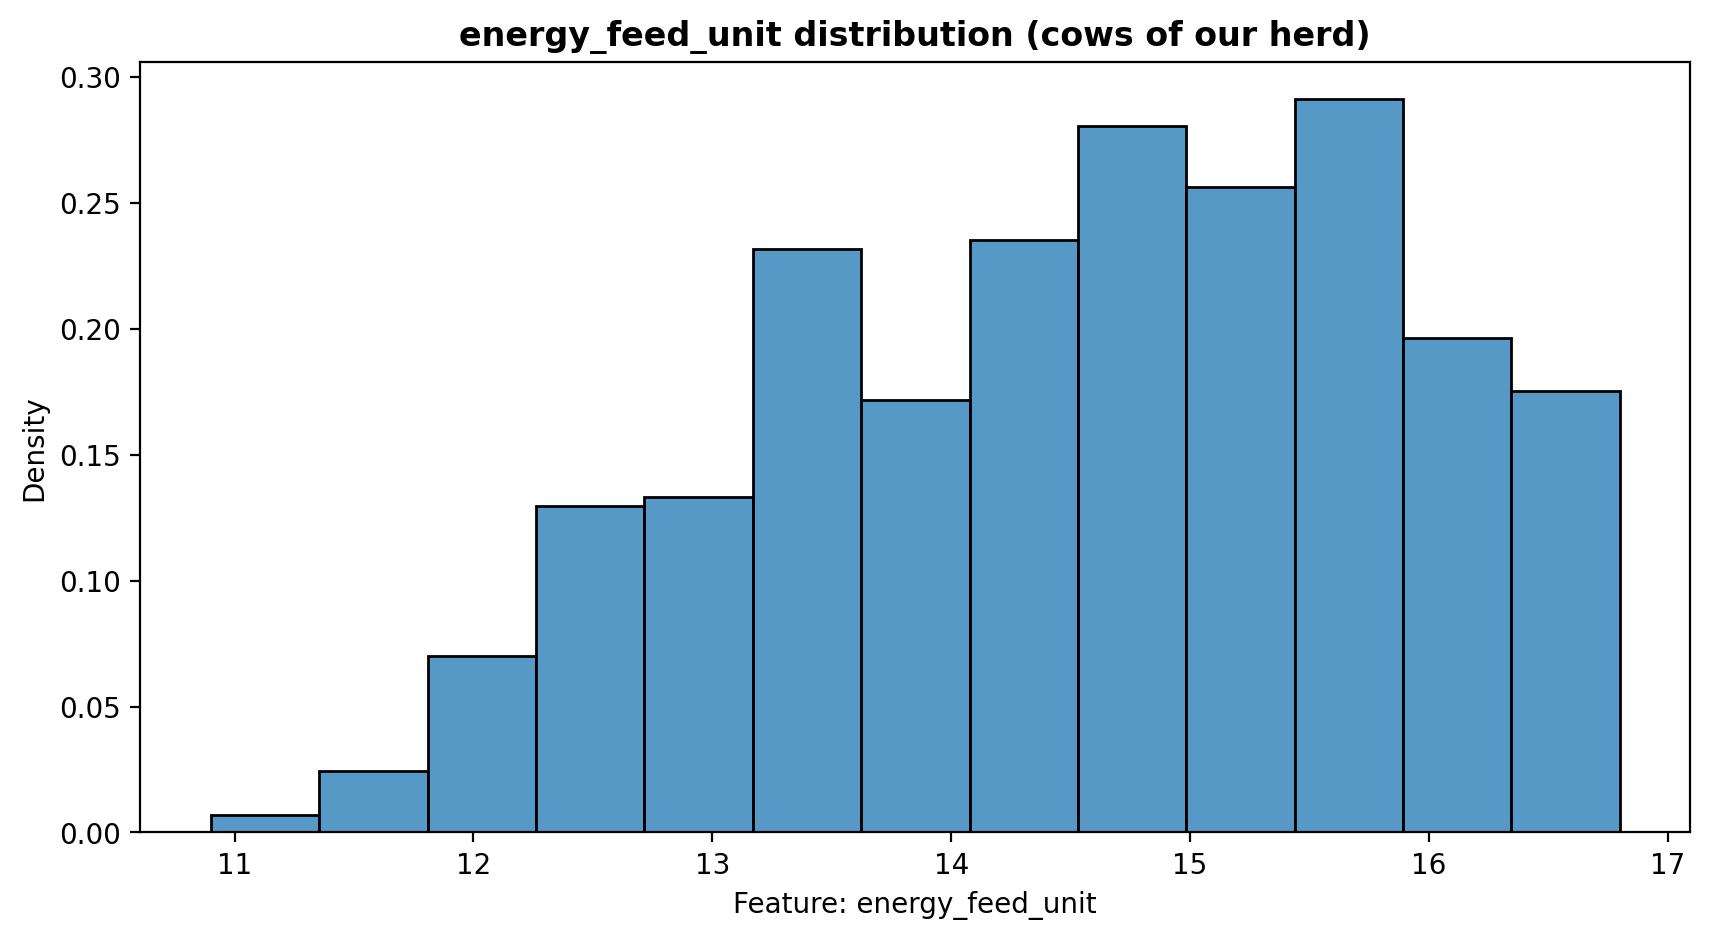

count    628.00
mean      14.55
std        1.30
min       10.90
25%       13.50
50%       14.70
75%       15.60
max       16.80
Name: energy_feed_unit, dtype: float64

In [31]:
# Initial distribution
draw_norm_histogram(data=data,
                    column='energy_feed_unit')

data['energy_feed_unit'].describe().round(2)

No anomalies were detected. Cows consume between 10.9 and 16.8 EFU, with a mean value of 14.55 EFU. Feed parameters are determined by the farm's technologists, so it is not possible to judge the nature of the distribution.

### Feature `crude_protein`

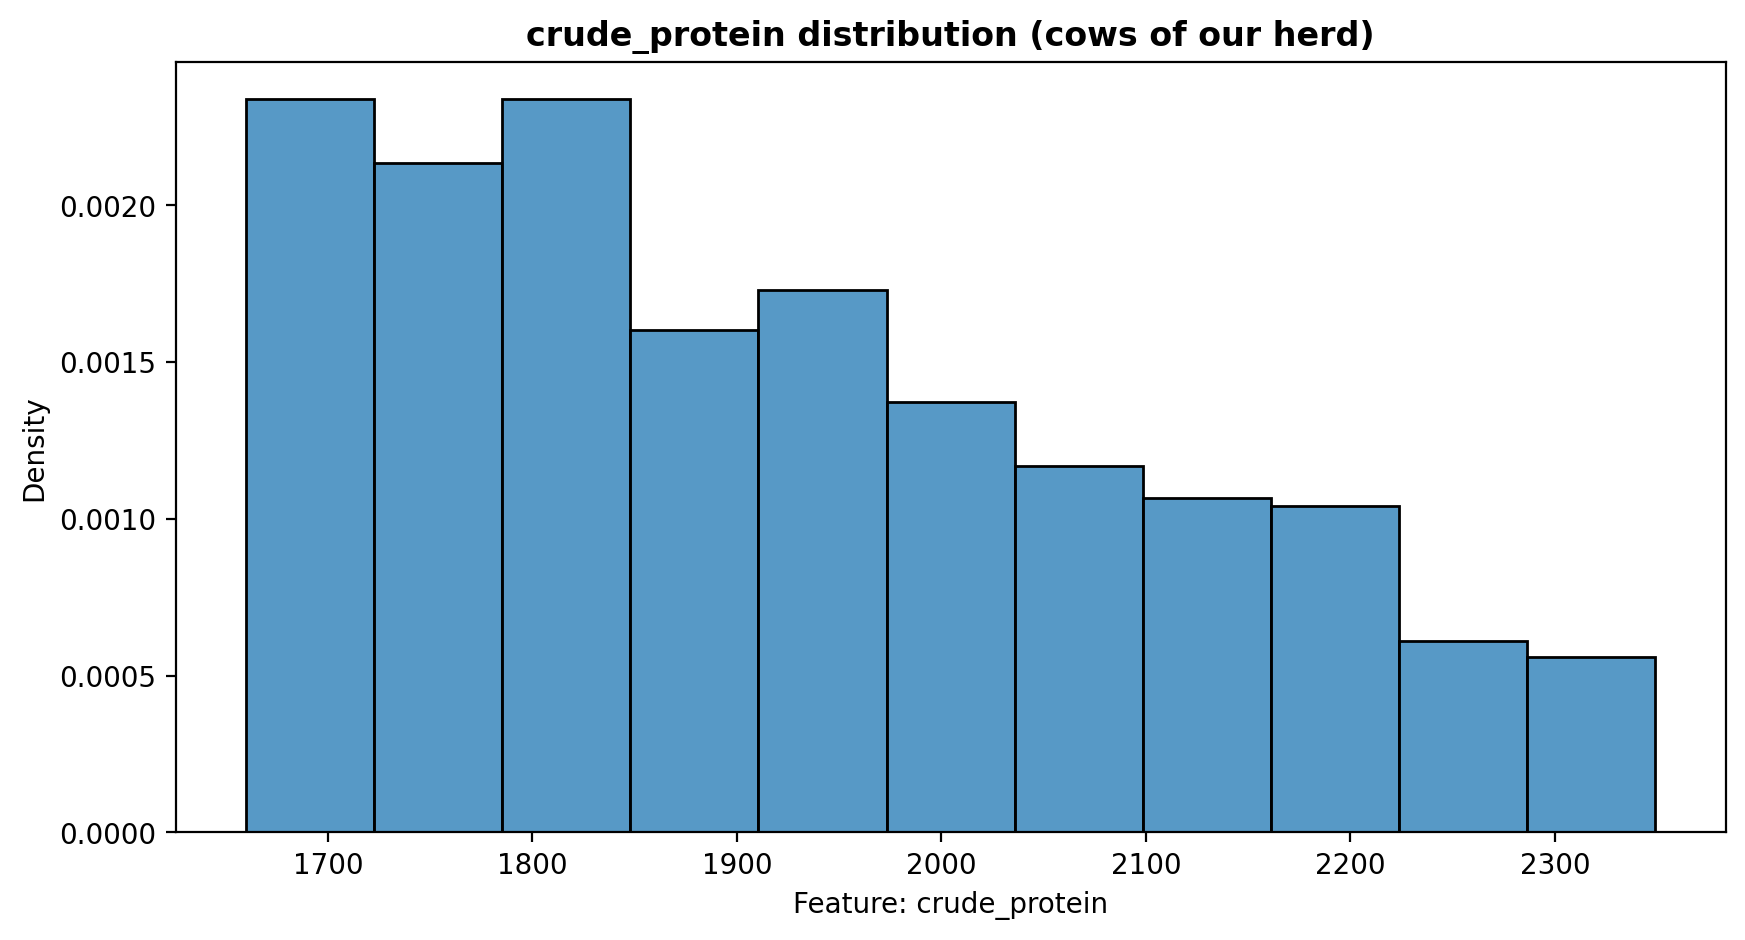

count     628.00
mean     1923.76
std       182.83
min      1660.00
25%      1771.75
50%      1888.00
75%      2062.25
max      2349.00
Name: crude_protein, dtype: float64

In [32]:
# Initial distribution
draw_norm_histogram(data=data,
                    column='crude_protein')

data['crude_protein'].describe().round(2)

No anomalies were detected. Cows consume between 1660g and 2349g of crude protein, with a mean value of 1924g. Feed parameters are determined by the farm's technologists, so it is not possible to judge the nature of the distribution.

### Feature `sugar_protein_ratio`

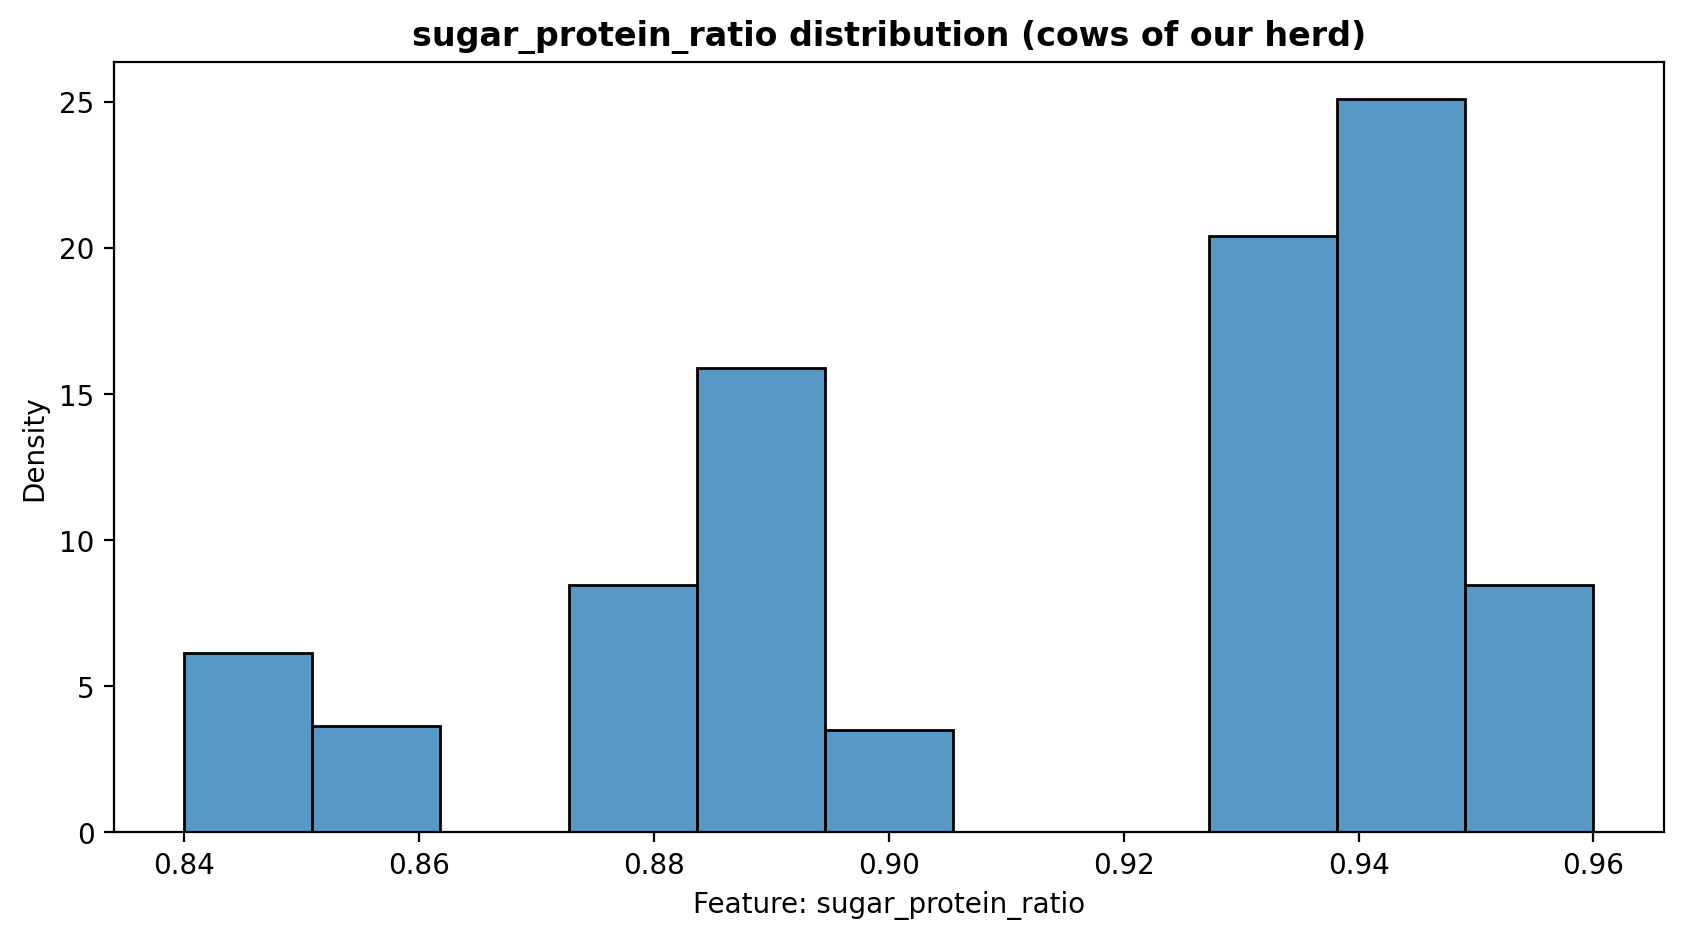

count    628.00
mean       0.91
std        0.03
min        0.84
25%        0.89
50%        0.93
75%        0.94
max        0.96
Name: sugar_protein_ratio, dtype: float64

In [33]:
# Initial distribution
draw_norm_histogram(data=data,
                    column='sugar_protein_ratio')

data['sugar_protein_ratio'].describe().round(2)

No anomalies were detected. SPR ranges from 0.84 to 0.96, with a mean value of 0.91. Feed parameters are determined by the farm's technologists, so it is not possible to judge the nature of the distribution.

On the graph, we see 3 clusters of values:
* less than 0.87;
* from 0.87 to 0.91;
* greater than 0.92.

### Feature `milk_fat`

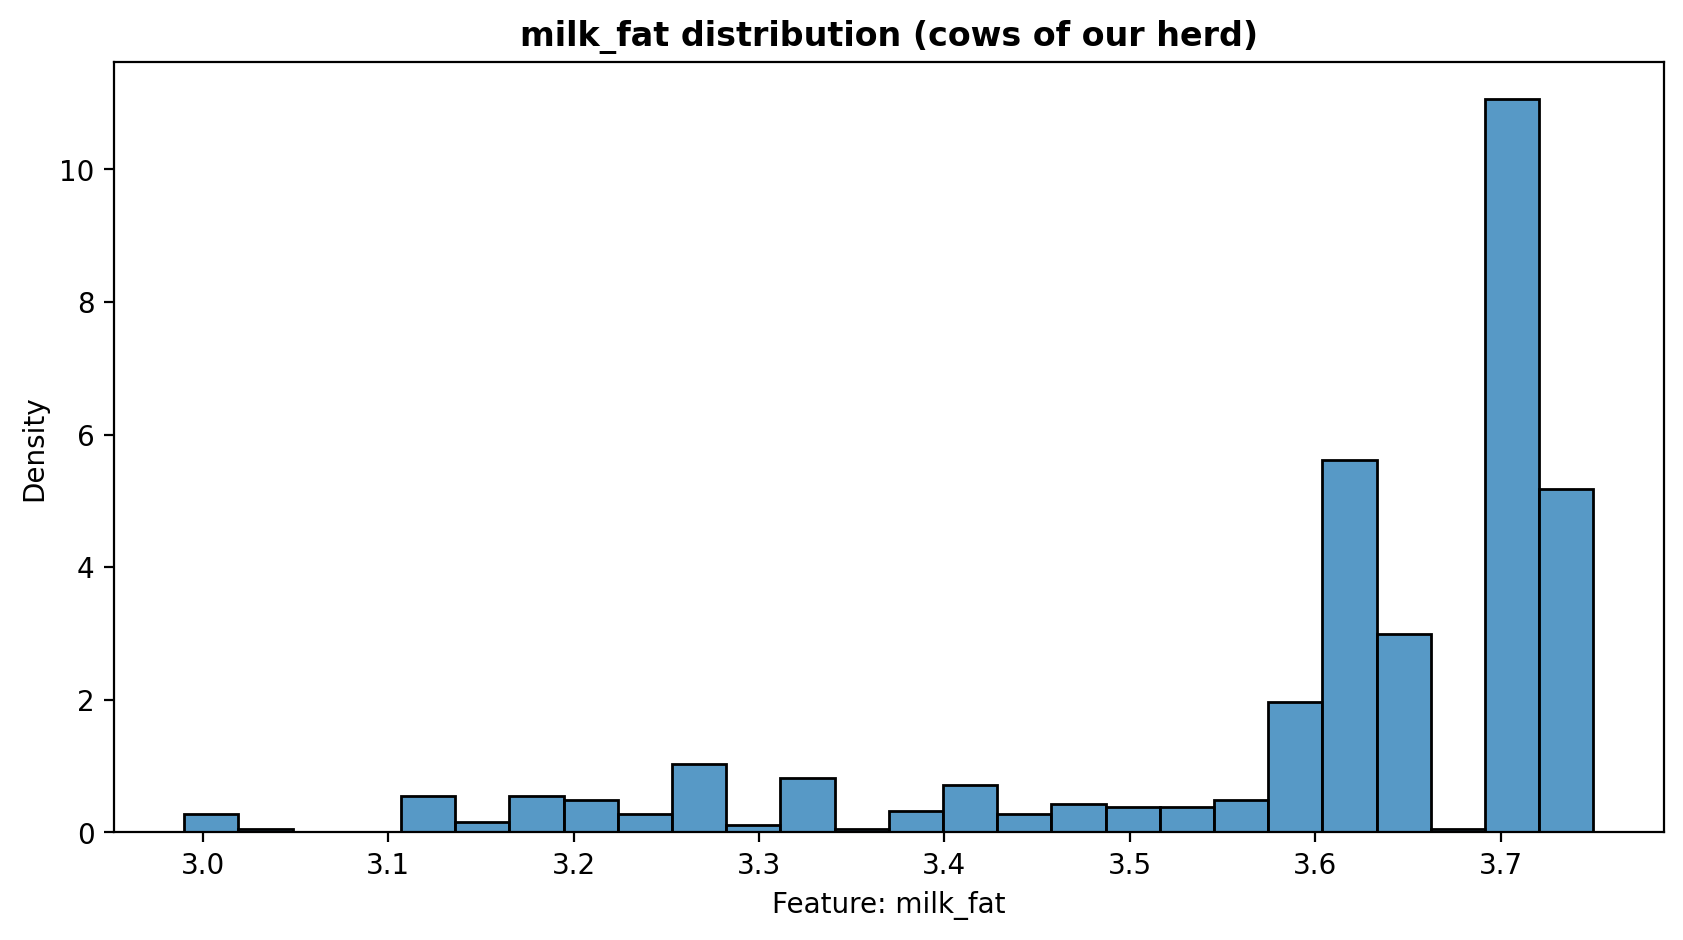

count    628.00
mean       3.60
std        0.17
min        2.99
25%        3.59
50%        3.65
75%        3.72
max        3.75
Name: milk_fat, dtype: float64

In [34]:
# Initial distribution
draw_norm_histogram(data=data,
                    column='milk_fat')

data['milk_fat'].describe().round(2)

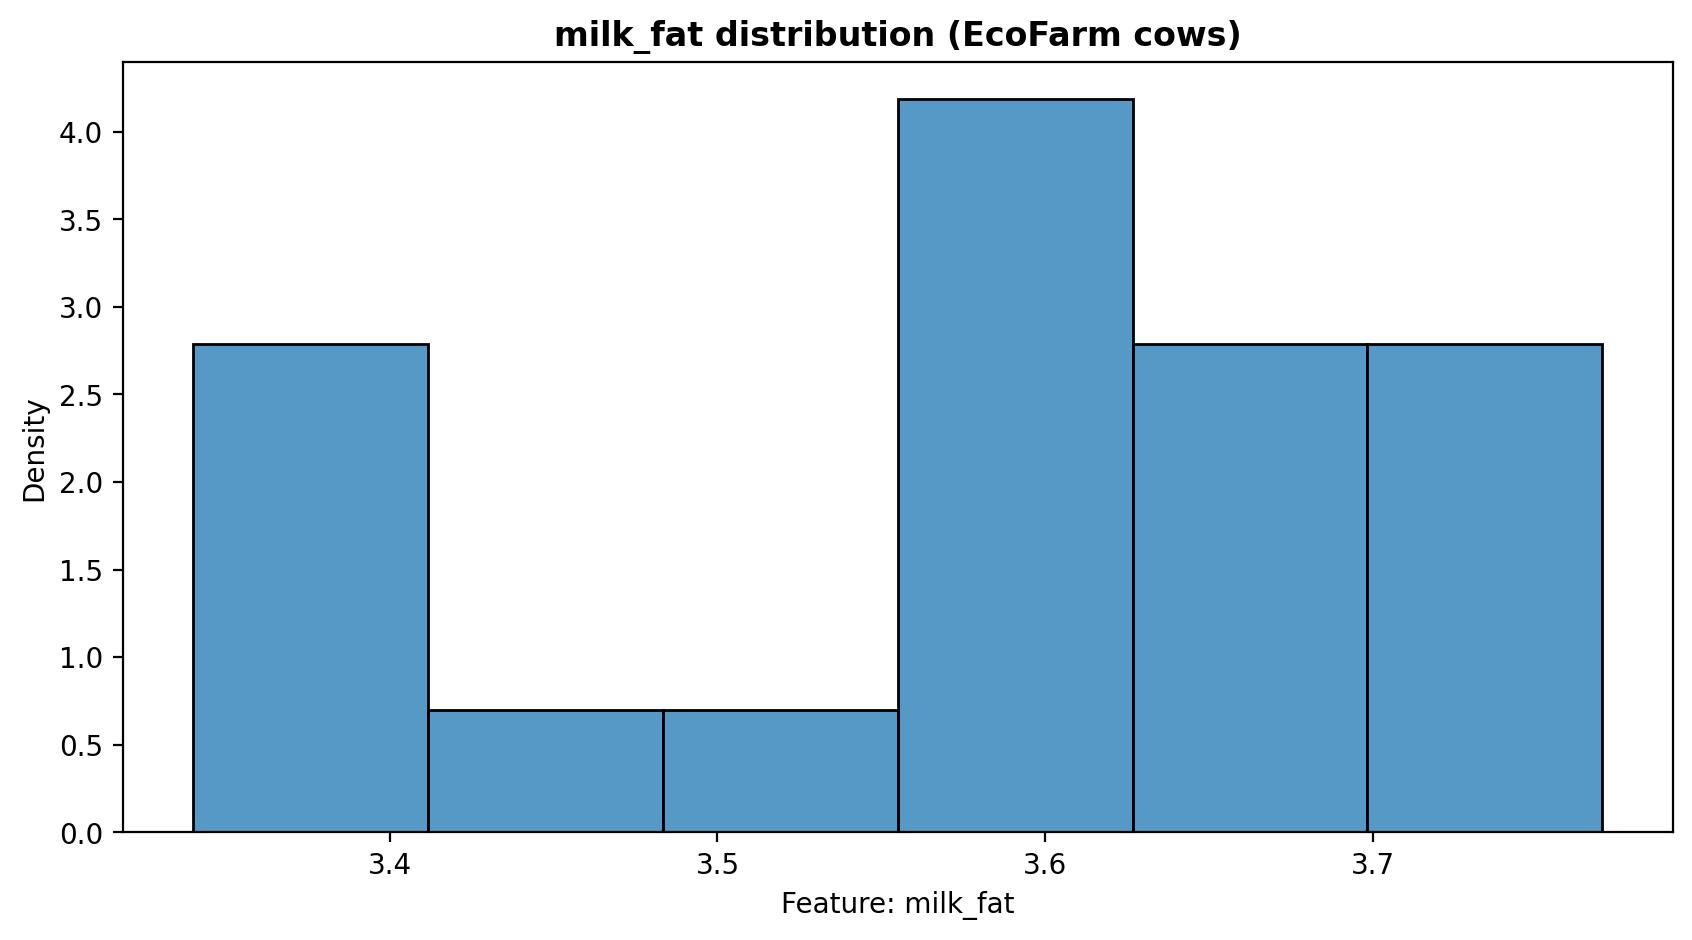

count    20.00
mean      3.58
std       0.13
min       3.34
25%       3.51
50%       3.59
75%       3.65
max       3.77
Name: milk_fat, dtype: float64

In [35]:
# Initial distribution
draw_norm_histogram(data=data_purchase,
                    column='milk_fat')

data_purchase['milk_fat'].describe().round(2)

In [36]:
# Combine the data
data_pivot = pd.concat([data['milk_fat'].describe().round(2), 
                        data_purchase['milk_fat'].describe().round(2)],
                        axis=1)
data_pivot.columns = ['milk_fat_herd', 'milk_fat_ecofarm']
data_pivot

milk_fat_herd  milk_fat_ecofarm
count         628.00             20.00
mean            3.60              3.58
std             0.17              0.13
min             2.99              3.34
25%             3.59              3.51
50%             3.65              3.59
75%             3.72              3.65
max             3.75              3.77

* No anomalies were detected.
* The fat content of the herd's milk ranges from 2.99 to 3.75%, with a mean value of 3.6%. The distribution of milk fat content does not follow a normal distribution, which may indicate a relationship with other parameters.
* The fat content of milk from cows at EcoFarm ranges from 3.34 to 3.77%, with a mean value of 3.58%. It is not possible to determine the distribution pattern due to the very small number of observations.
* Overall the fat content of milk from cows at EcoFarm is slightly higher that from cows of the herd.

### Feature `milk_protein`

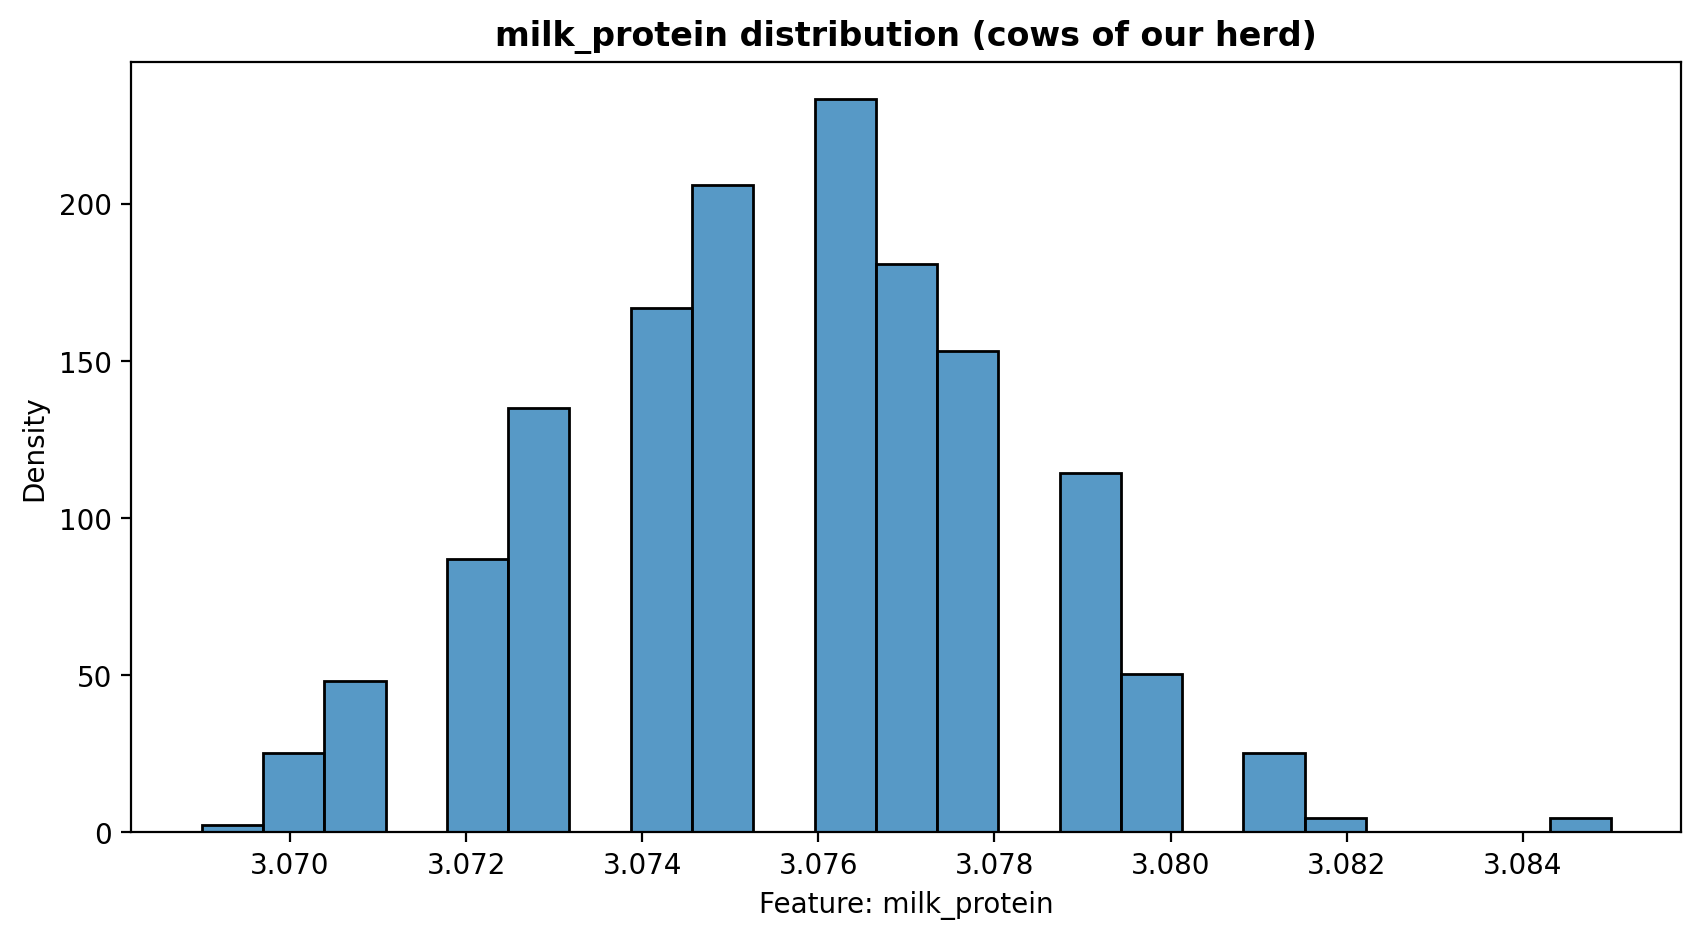

count    628.000
mean       3.076
std        0.003
min        3.069
25%        3.074
50%        3.076
75%        3.077
max        3.085
Name: milk_protein, dtype: float64

In [37]:
# Initial distribution
draw_norm_histogram(data=data,
                    column='milk_protein')

data['milk_protein'].describe().round(3)

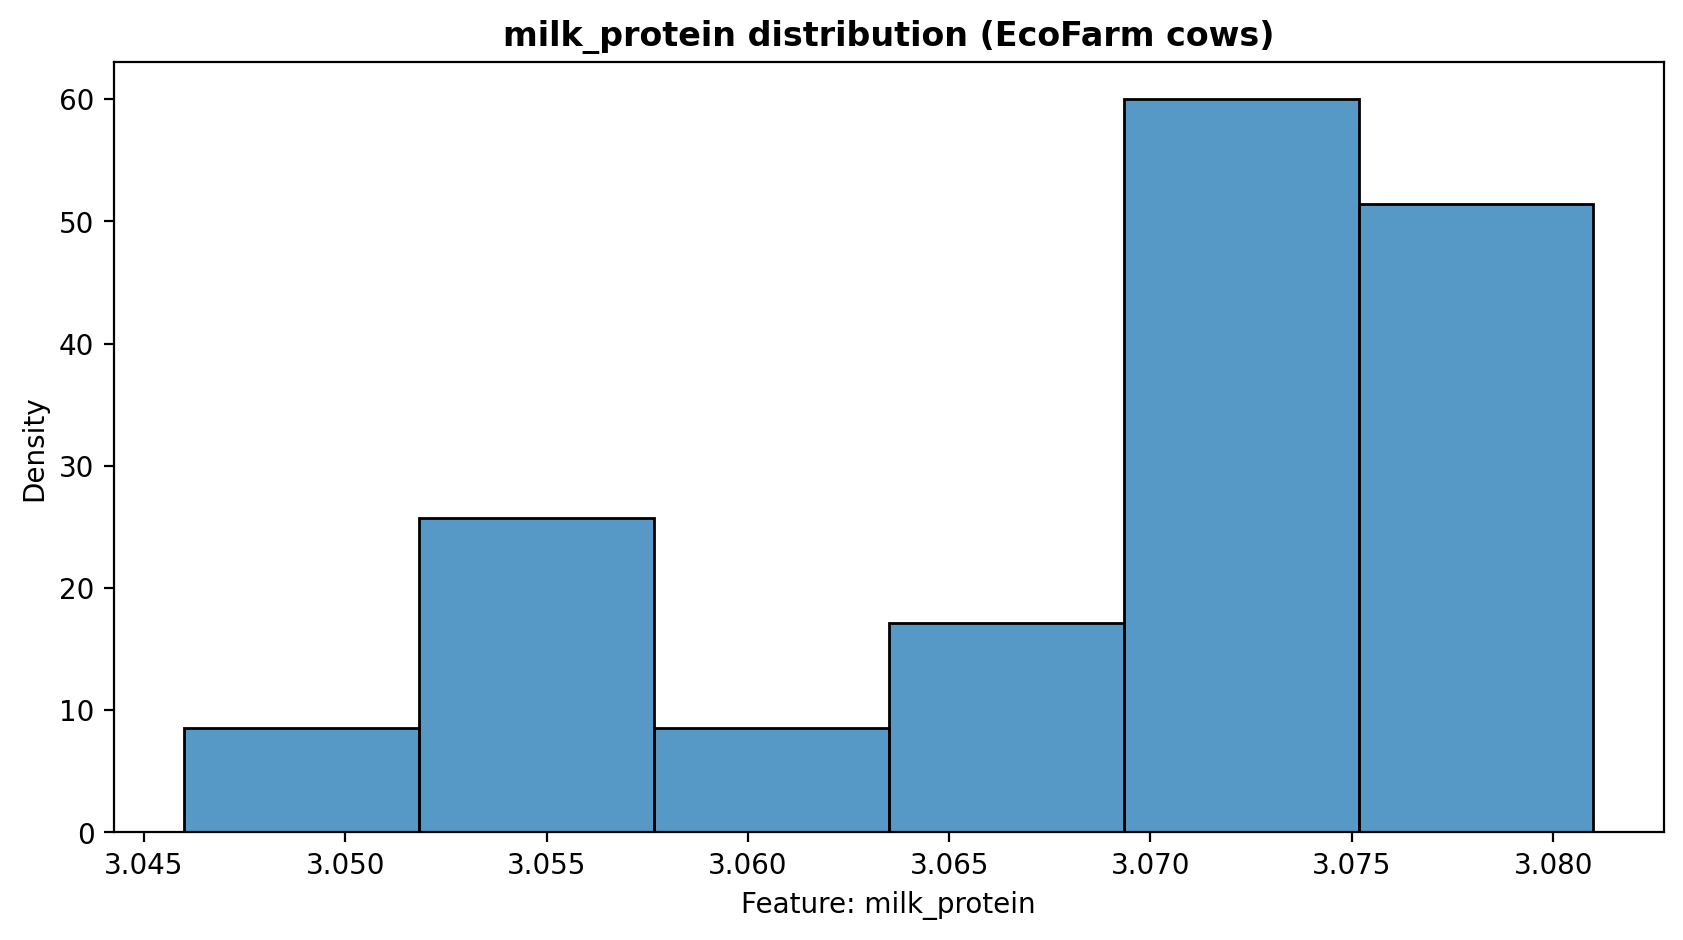

count    20.000
mean      3.070
std       0.010
min       3.046
25%       3.064
50%       3.074
75%       3.076
max       3.081
Name: milk_protein, dtype: float64

In [38]:
# Initial distribution
draw_norm_histogram(data=data_purchase,
                    column='milk_protein')

data_purchase['milk_protein'].describe().round(3)

In [39]:
# Combine the data
data_pivot = pd.concat([data['milk_protein'].describe().round(3), 
                        data_purchase['milk_protein'].describe().round(3)], 
                        axis=1)
data_pivot.columns = ['milk_protein_herd', 'milk_protein_ecofarm']
data_pivot

milk_protein_herd  milk_protein_ecofarm
count            628.000                20.000
mean               3.076                 3.070
std                0.003                 0.010
min                3.069                 3.046
25%                3.074                 3.064
50%                3.076                 3.074
75%                3.077                 3.076
max                3.085                 3.081

* No anomalies were detected.
* The protein content of the herd's milk ranges from 3.069% to 3.085%, with a mean value of 3.076%. The distribution of milk protein content resembels a normal distribution.
* The protein content of the EcoFarm cows milk ranges from 3.046% to 3.081%, with a mean value of 3.07%. It is not possible to determine the distribution pattern due to the very small number of observations.
* Protein contain is almost the same for herd cows and EcoFarm cows.

### Feature `breed`

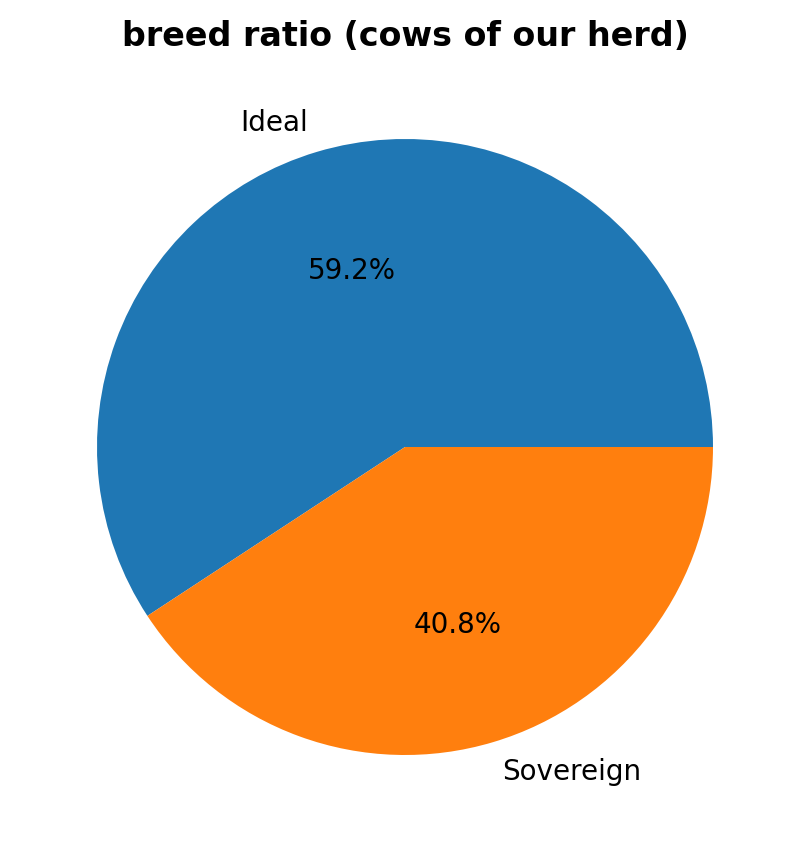

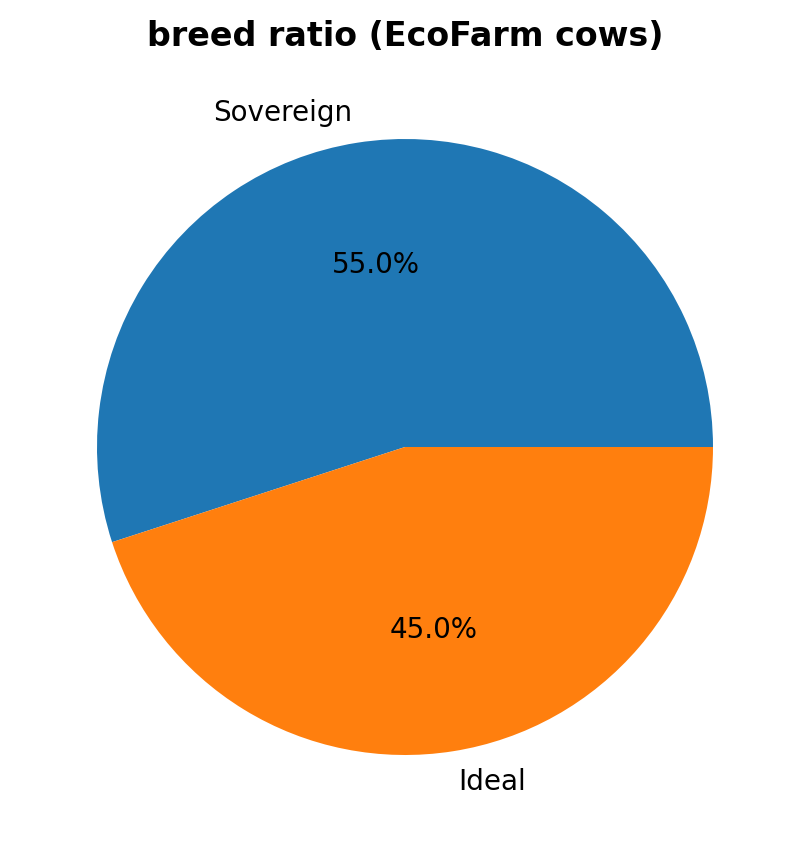

In [40]:
draw_piechart(data=data, 
              column='breed')

draw_piechart(data=data_purchase, 
              column='breed')

The herd is dominated by cows of the Ideal breed (59.2%), and in EcoFarm - cows of the Sovereign breed (55%).

### Feature `pasture_type`

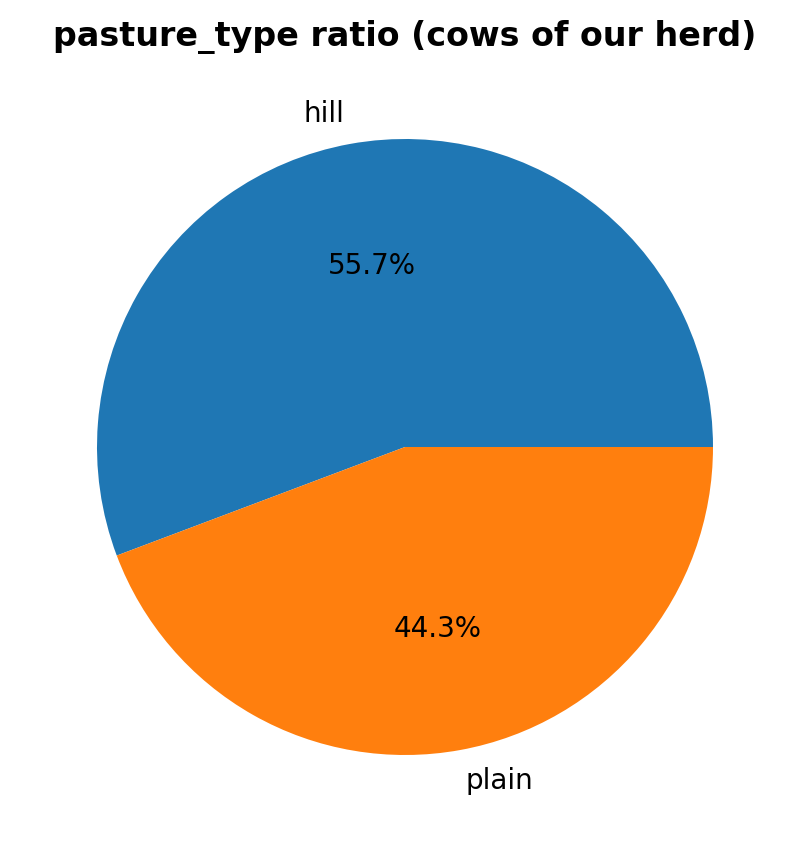

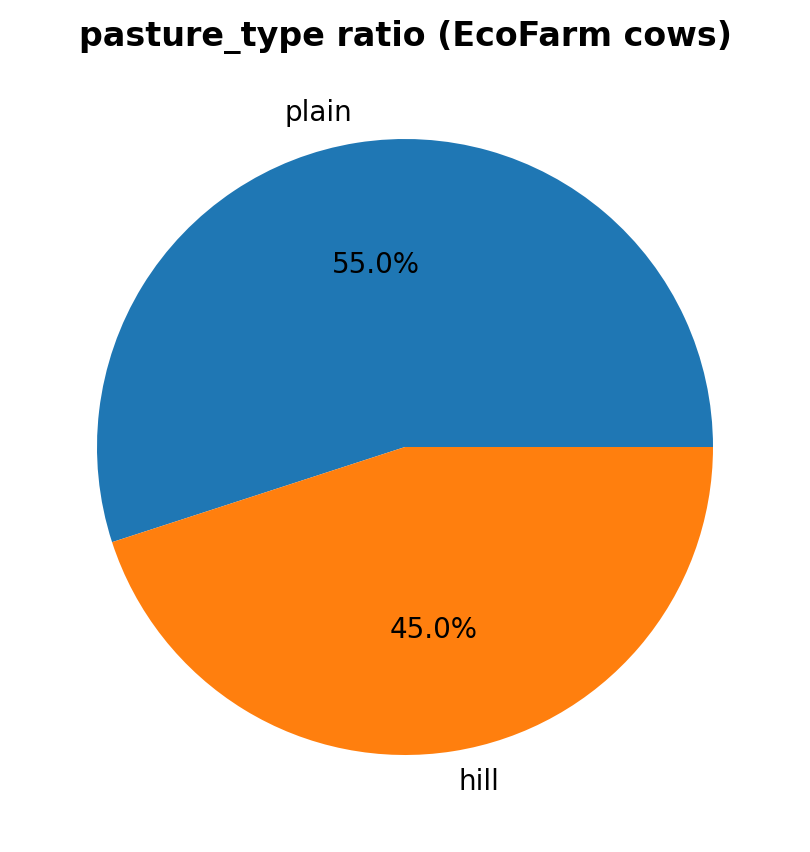

In [41]:
draw_piechart(data=data, 
              column='pasture_type')

draw_piechart(data=data_purchase, 
              column='pasture_type')

The herd is dominated by cows grazing on hilly pastures (55.7%), while in EcoFarm, on the contrary, 55% of cows graze on plain pastures.

### Feature `age`

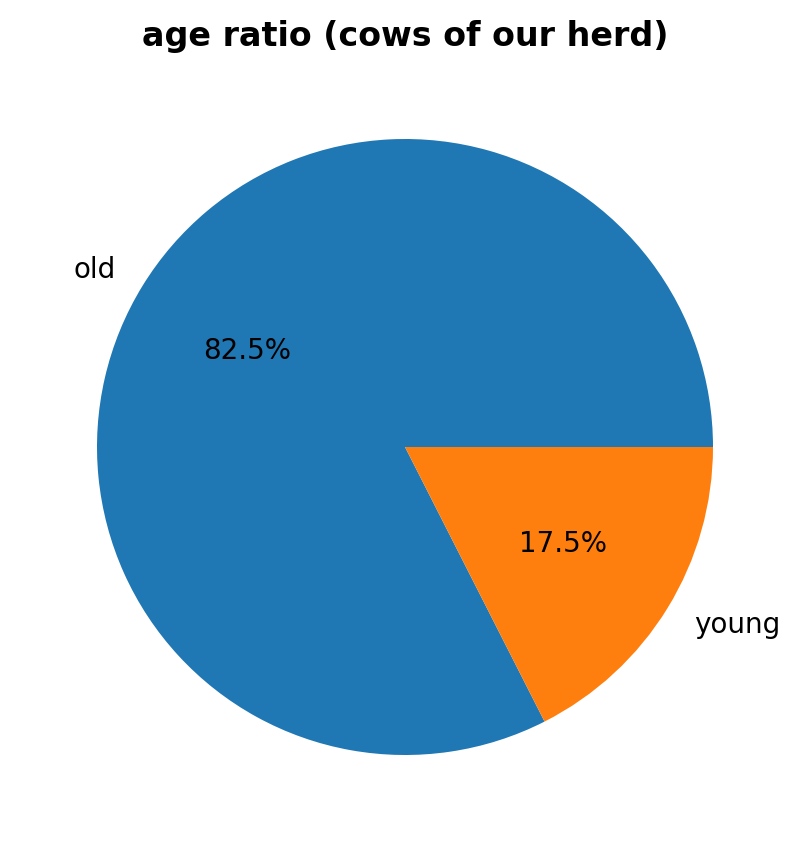

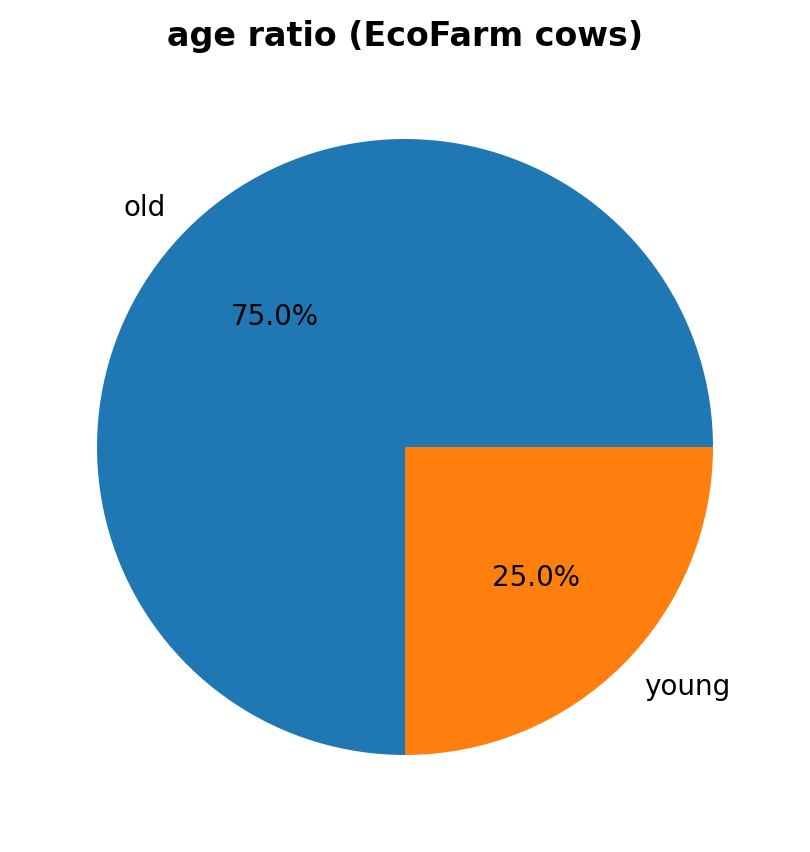

In [42]:
draw_piechart(data=data, 
              column='age')

draw_piechart(data=data_purchase, 
              column='age')

The vast majority (82.5%) of the cows in the herd are over two years old. The situation is similar in EcoFarm - 75% of cows are over two years old.

### Target feature `milk_tastе`

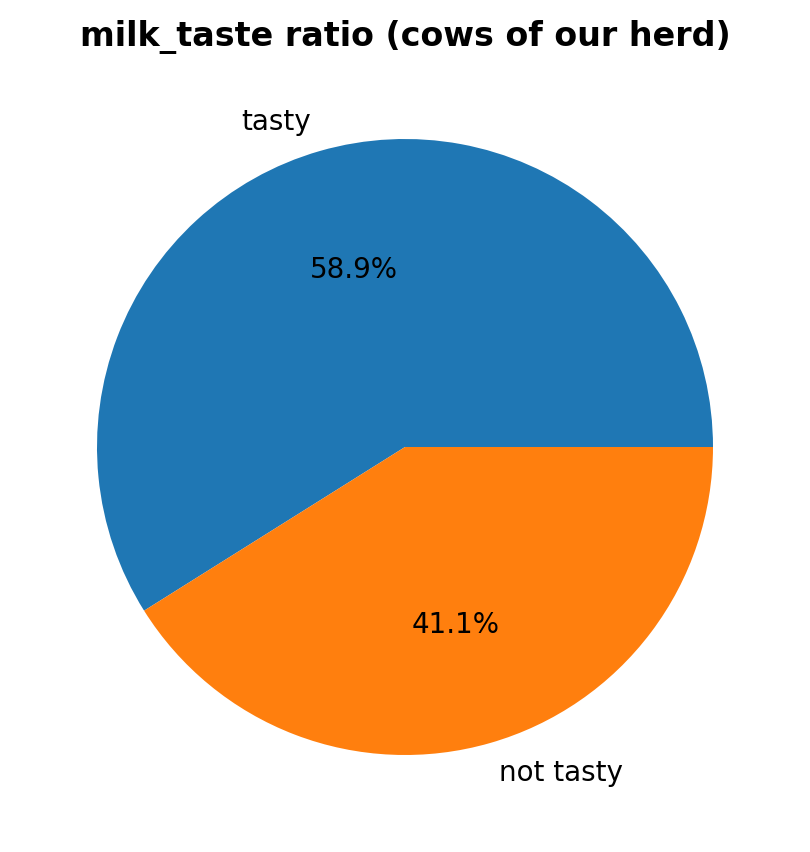

In [43]:
draw_piechart(data=data, 
              column='milk_taste')

The majority (58.9%) of the cows in the herd produce tasty milk.

### Correlation analysis

The distribution of the milk_yield and milk_fat features is normal, but we cannot judge the nature of the distribution of the energy_feed_unit, sugar_protein_ratio and crude_protein features, since the cow's feed parameters are set by the farm technologists and are not random variables. The milk_fat feature is not normally distributed.

Since the dataset contains a feature that is not normally distributed, we cannot use the Pearson correlation coefficient. To look at the relationships between all features in the dataset, we will use phi-coefficient.

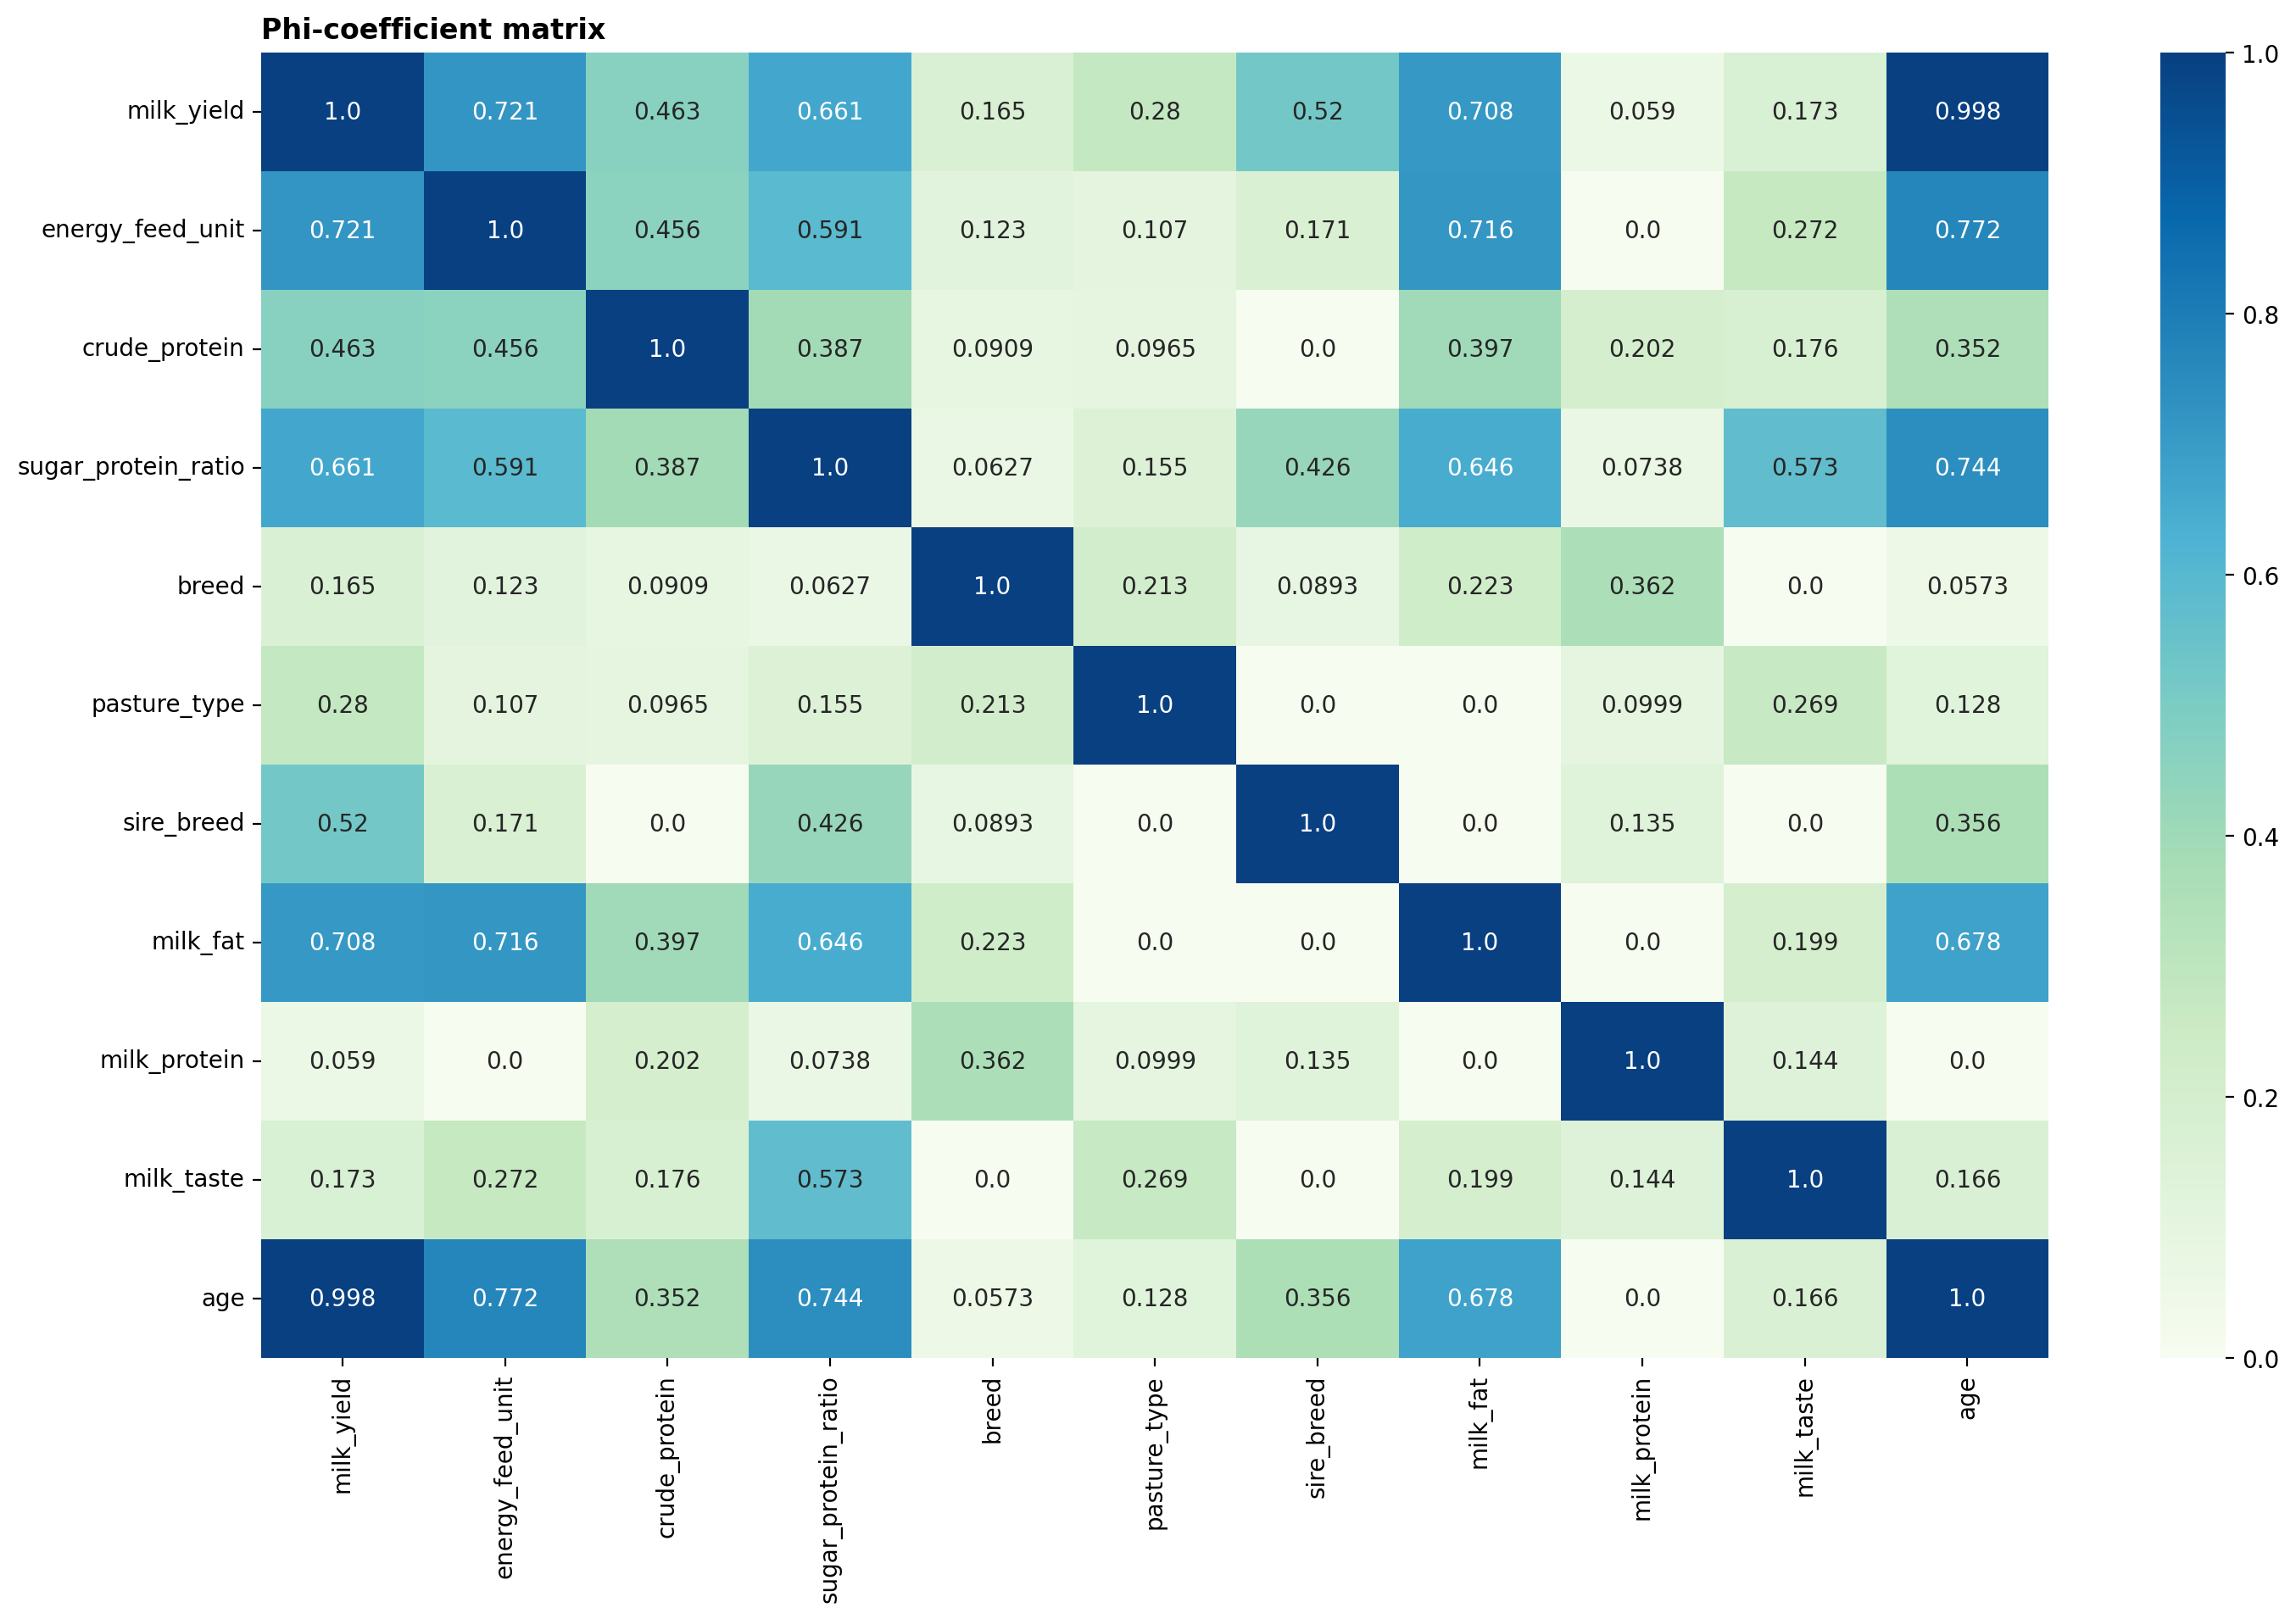

In [44]:
# Phi-coefficient matrix
corr = data.phik_matrix(interval_cols=['milk_yield',
                                       'energy_feed_unit',
                                       'crude_protein',
                                       'sugar_protein_ratio',
                                       'milk_fat',
                                       'milk_protein'])
fig, ax = plt.subplots(figsize = (17,10))
ax.set_title('Phi-coefficient matrix',
             loc='left',
             fontweight='semibold')
ax = sns.heatmap(corr,
                 xticklabels=corr.columns.values,
                 yticklabels=corr.columns.values,
                 vmin=0,
                 vmax=1,
                 cmap='GnBu',
                 annot=True,
                 fmt='.3')
plt.show()

In the matrix we see a strong connection between the target feature `milk_yield` and the input `energy_feed_unit`, `sugar_protein_ratio`, `milk_fat` and `age`.
We remember that the presence of a connection does not indicate cause and effect. It is logical to assume that the fat content of milk cannot increase milk yield.

Target feature `milk_taste` doesn't have strong relationships with any of the input features, apart from `sugar_protein_ratio`.

Let's visualize the relationships between target feature `milk_yield` and quantitative features using scatter plots.

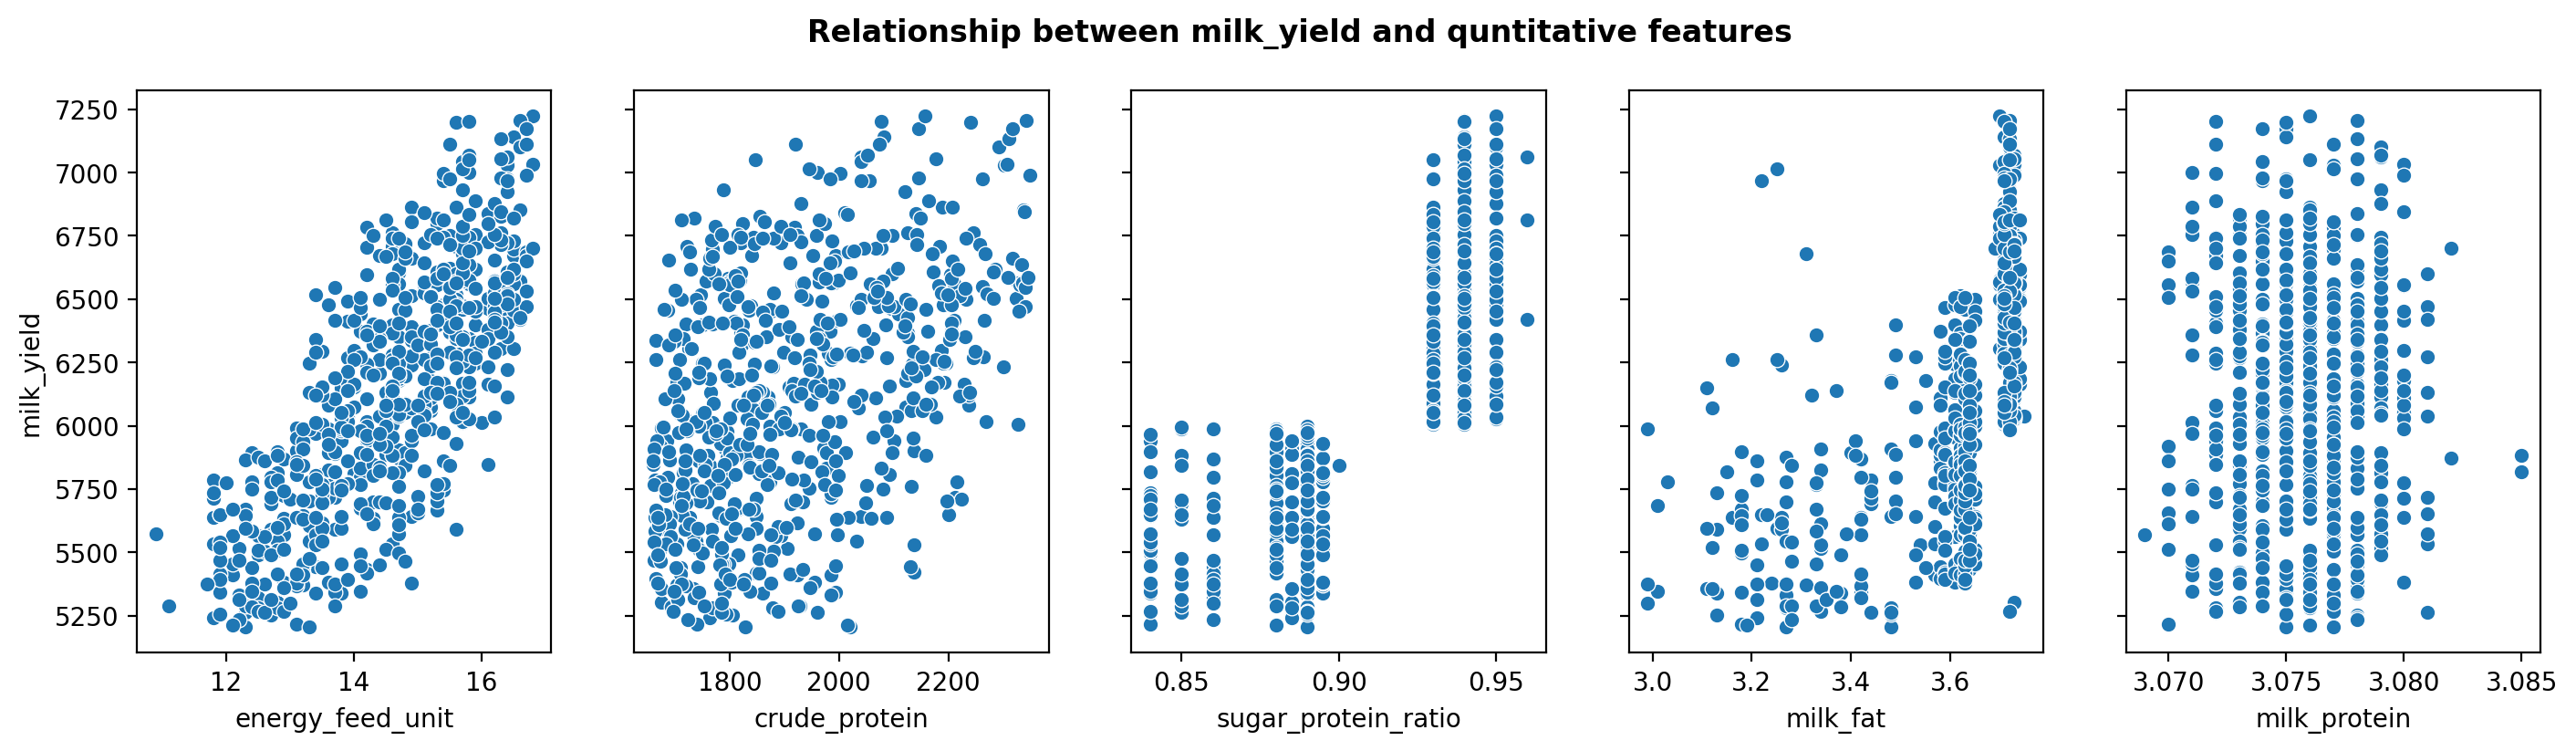

In [45]:
draw_scatterplot(data=data, 
                 column='milk_yield')

Scatter plots show:
- non-linear relationship between `milk_yield` and `energy_feed_unit`;
- no relationship between `milk_yield` and `crude_protein`;
- non-linear relationship between `milk_yield` and `sugar_protein_ratio`;
- non-linear relationship between `milk_yield` and `milk_fat`;
- no relationship between `milk_yield` and `milk_protein`.

Let's look at the relationships in subgroups.

### Relationship between `milk_yield` and quntitative features depending on `breed`

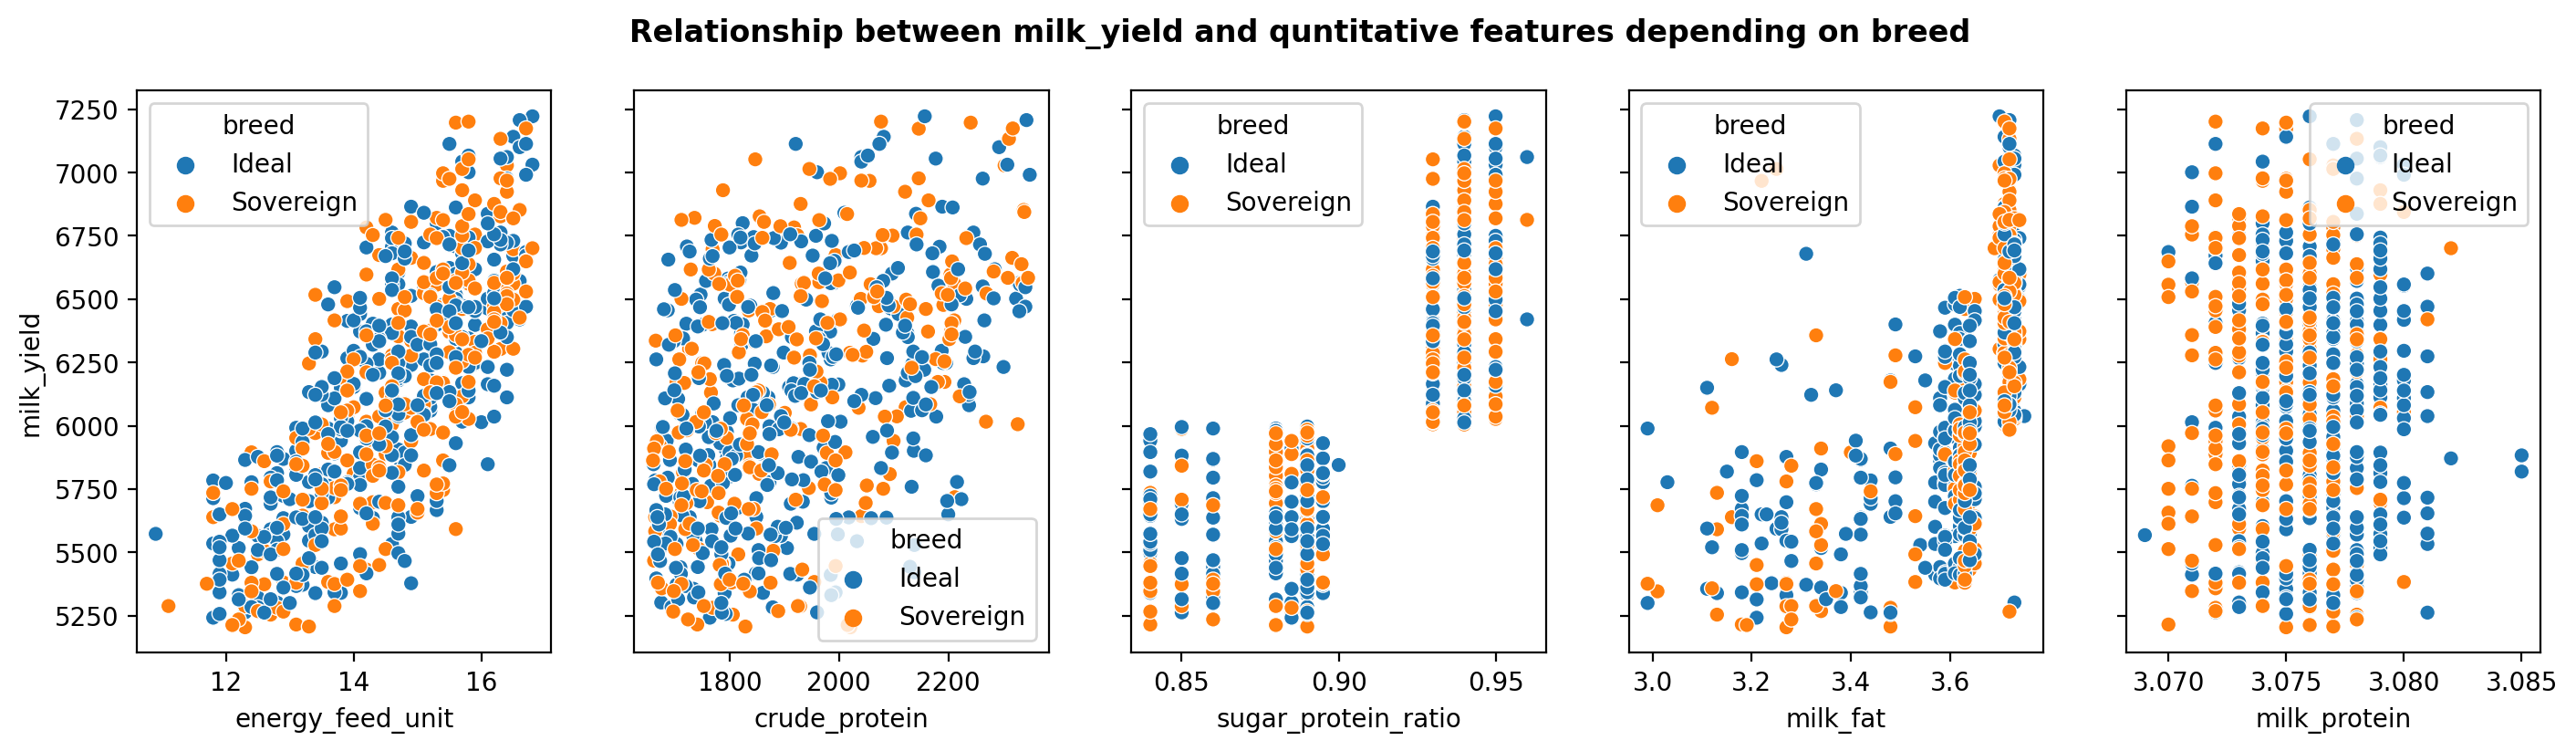

In [46]:
draw_scatterplot(data=data, 
                 column='milk_yield', 
                 hue='breed')

Scatterplots showed similar values for both breeds. The breed of the cow does not affect the value of `milk_yield`.

### Relationship between `milk_yield` and quntitative features depending on `age`

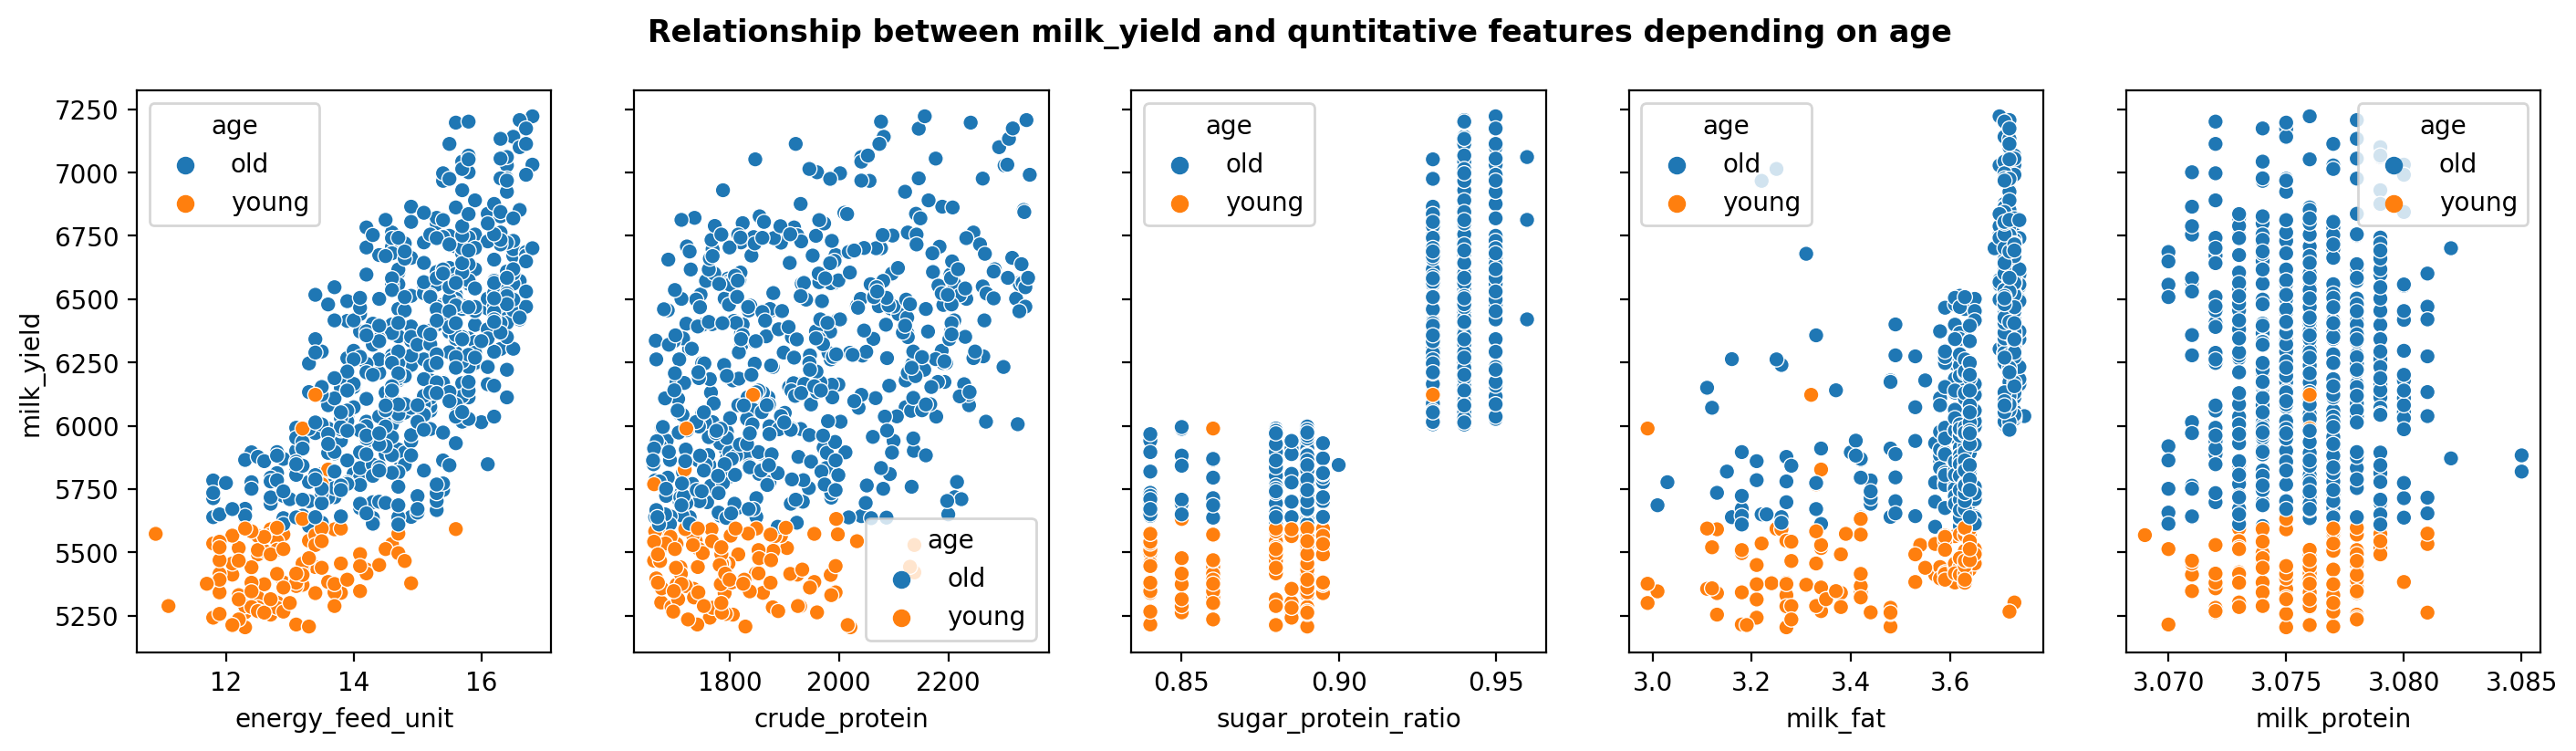

In [47]:
draw_scatterplot(data=data, 
                 column='milk_yield', 
                 hue='age')

We see similar types of `milk_yield` and quantitative features relationships, however, the milk yield of young cows is generally significantly less than the milk yield of cows older than 2 years. The age of the cow significantly influences the target feature `milk_yield`.

### Relationship between `milk_yield` and quntitative features depending on `pasture_type`

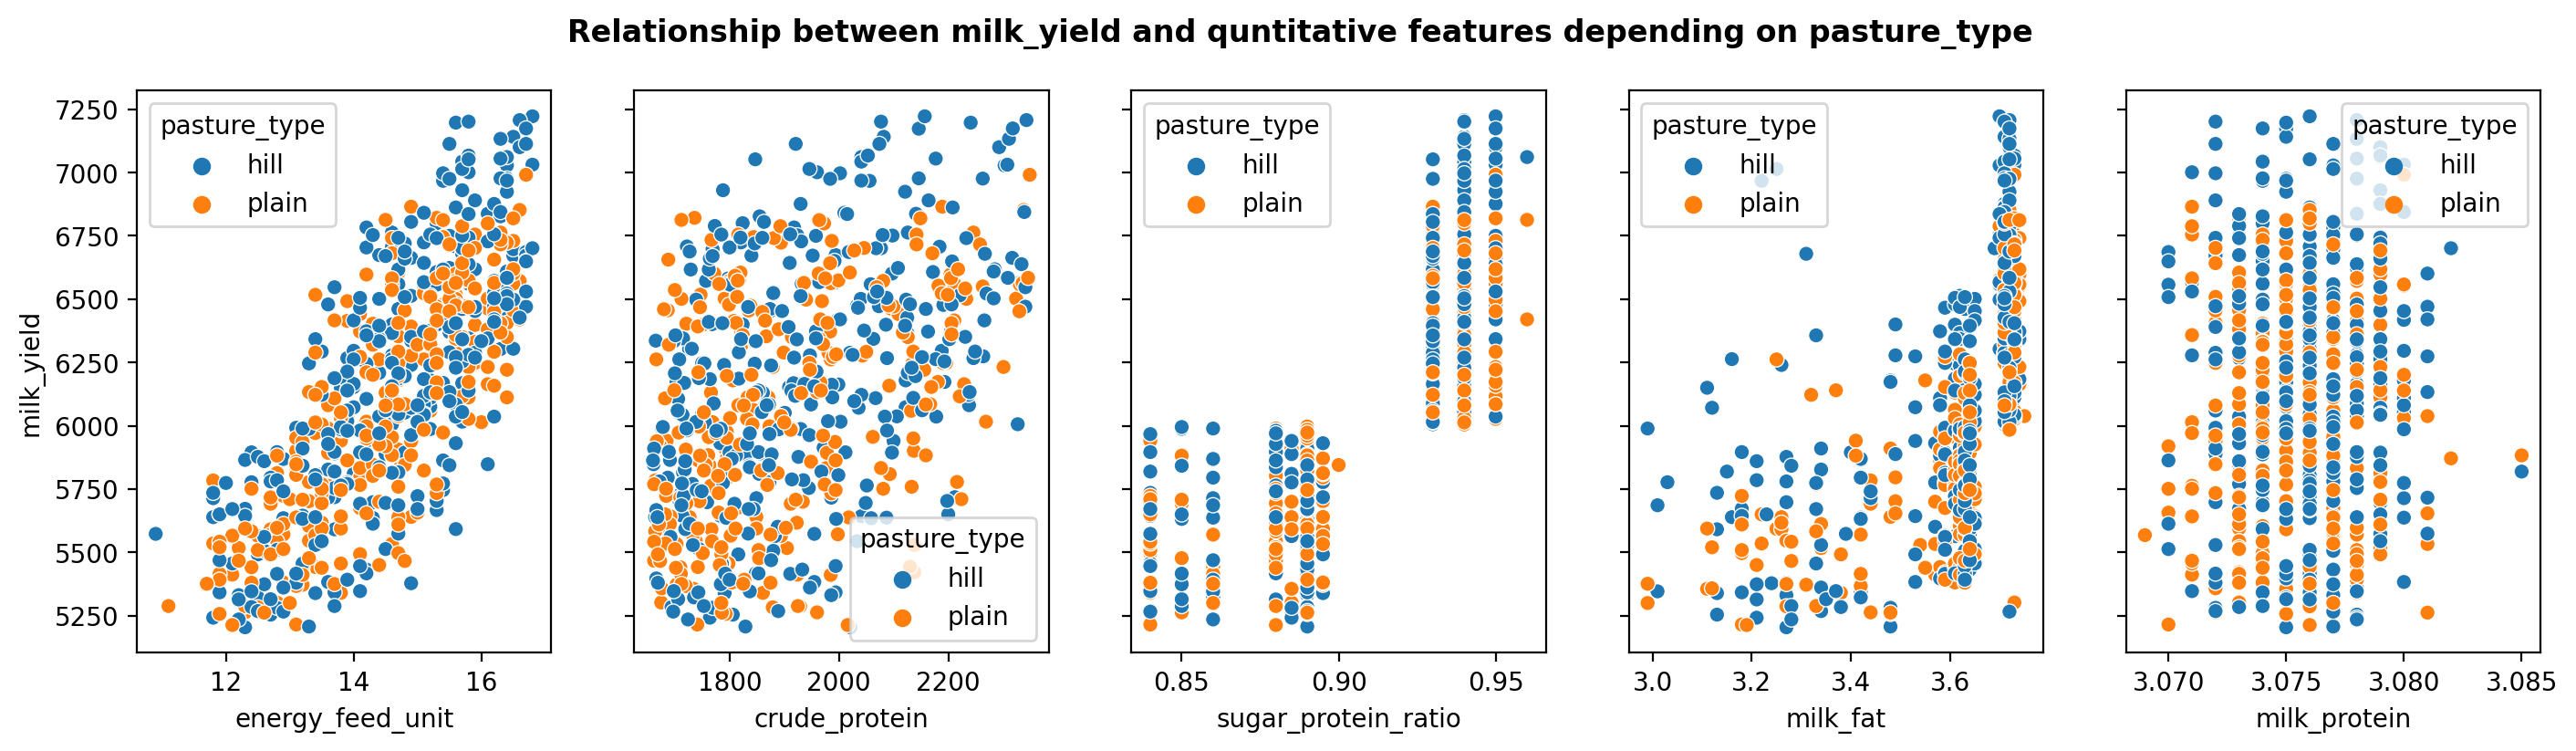

In [48]:
draw_scatterplot(data=data, 
                 column='milk_yield', 
                 hue='pasture_type')

We see similar relationships. Pasture type do not influence `milk_yield`.

### Summry

- An anomalous value in milk yield was detected; it was removed from the data set due to the impossibility of restoring the correct value.
- Of all the parameters of the cows in the herd, only `milk_yield` and `milk_protein` follow a normal distribution.
- Nutrition parameters are set by farm technologists and are not random variables, therefore, the type of their distribution can take any form.
- It is not possible to draw a conclusion about the types of distributions of parameters of EcoFarm cows due to the very small sample size (only 20 records).

To improve the data, it is necessary to obtain information from farm technologists about the reference values of numerical features, as well as about feeding rates and dependence on other parameters.

In the provided data set, only 1 parameter greatly influences `milk_yield` - the age of the cow.
For the zero iteration of constructing a linear model, we will use the following features as is:
- breed
- pasture_type,
- sire_breed,
- age,
- energy_feed_unit,
- sugar_protein_ratio,
- crude_protein.

Then we will experiment with converting sugar_protein_ratio into a categorical feature and introducing new features.

## Machine learning models for `milk_yield` prediction

Milk yield is a quantitative feature so we are solving regression problem. Our customer requires simple and easy to interpret model that is why we are going to use linear regression model.

In [49]:
# Create a variable to store linear regression models
lr_models = []

# Create a table with models parameters
lr_models_metrics = pd.DataFrame({'Model': [],
                                  'rmse': [],
                                  'mae': [], 
                                  'r2': [], 
                                  'confidence_interval_95_a': [],
                                  'confidence_interval_95_b': []})

In [50]:
# Function that performs residual analysis
def residual_analysis(y_test, predictions):
    # Residual analysis
    true_predicted = pd.DataFrame({'true_y': y_test, 'predicted_y': predictions, 'residuals': y_test-predictions})
    display(true_predicted.head(10))
    
    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12,12))
    bins = axes[0].hist(x=true_predicted['residuals'], bins=20)
    axes[0].set_title('Histogram of Distribution of Residuals',
                      loc='left',
                      fontweight='semibold')
    axes[0].xaxis.set_major_locator(ticker.MultipleLocator(100))
    axes[0].xaxis.set_minor_locator(ticker.MultipleLocator(20))
    axes[0].set_xlabel('Residuals')
    axes[0].set_ylabel('Number of residuals')
    axes[0].vlines(x=true_predicted['residuals'].mean(),
                   colors='orange', 
                   ymin=bins[0].min(), 
                   ymax=bins[0].max(), 
                   label='Mean')
    axes[0].vlines(x=true_predicted['residuals'].median(), 
                   colors='orange', 
                   ymin=bins[0].min(), 
                   ymax=bins[0].max(), 
                   linestyles='--', 
                   label='Median')
    axes[0].legend()
    axes[0].grid()
    
    axes[1].scatter(x=predictions, y=true_predicted['residuals'])
    axes[1].set_xlabel('Predictions')
    axes[1].set_ylabel('Residuals')
    axes[1].set_title('Analysis of Residual Variance',
                      loc='left',
                      fontweight='semibold')
    axes[1].hlines(y=0,
                   colors='orange',
                   xmin=true_predicted['predicted_y'].min()-50,
                   xmax=true_predicted['predicted_y'].max()+50,
                   lw=3)
    axes[1].grid()
    plt.show()

### Model 1

Using common sense, to build a model for the target feature `milk_yield`, we will remove the milk parameters (fat, protein, etc) since they do not affect it. The rest of the features we will take as is.

In [51]:
num_columns = ['energy_feed_unit', 'crude_protein',
               'sugar_protein_ratio', 'milk_fat', 'milk_protein']

cat_columns = ['breed', 'pasture_type', 
               'sire_breed', 'age']

# Separate input and target features
X = data.drop('milk_yield', axis=1)
y = data['milk_yield']

# Train/Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=RANDOM_STATE)

# Scale numeric features with Standard Scaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[num_columns])
X_test_scaled = scaler.transform(X_test[num_columns])
    
# Encode categorical features with OneHotEncoder
encoder = OneHotEncoder(drop='first', sparse_output=False)
X_train_encoded = encoder.fit_transform(X_train[cat_columns])
X_test_encoded = encoder.transform(X_test[cat_columns])
encoder_columns = encoder.get_feature_names_out()
    
# Create new data set with encoded and scaled features
X_train_encoded = pd.DataFrame(X_train_encoded, columns=encoder_columns)
X_test_encoded = pd.DataFrame(X_test_encoded, columns=encoder_columns)
    
X_train_scaled = pd.DataFrame(X_train_scaled, columns=num_columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=num_columns)
    
X_train = pd.concat([X_train_encoded, X_train_scaled], axis=1)
X_test = pd.concat([X_test_encoded, X_test_scaled], axis=1)

X_train.head()

breed_Sovereign  pasture_type_plain  sire_breed_Sovereign  age_young  \
0              1.0                 0.0                   1.0        0.0   
1              1.0                 0.0                   1.0        1.0   
2              0.0                 1.0                   0.0        0.0   
3              0.0                 0.0                   0.0        0.0   
4              0.0                 1.0                   0.0        0.0   

   energy_feed_unit  crude_protein  sugar_protein_ratio  milk_fat  \
0          1.502378       1.079523             0.837130  0.562532   
1         -1.557270      -0.196920            -0.703660 -1.601817   
2          0.125537      -1.386085            -1.011818 -2.563750   
3         -0.103937       0.752230             0.837130  0.081565   
4         -1.098323       0.828598            -0.703660  0.201807   

   milk_protein  
0     -0.679069  
1     -1.452568  
2      1.254677  
3      1.254677  
4      0.094429


Linear regression coefficients:
breed_Sovereign                 : -21.69
pasture_type_plain              : -67.146
sire_breed_Sovereign            : -247.62
age_young                       : -223.15
energy_feed_unit                : +143.71
crude_protein                   : +58.343
sugar_protein_ratio             : +156.38
milk_fat                        : +29.124
milk_protein                    : -35.49
w0                              : +6329.9

Quality metrics:
RMSE = 207.72
MAE = 161.78
R2 = 0.788



true_y  predicted_y   residuals
582    5980  6056.878662  -76.878662
592    6512  6453.962116   58.037884
551    5392  5473.921434  -81.921434
214    5604  5685.785317  -81.785317
486    5667  5972.828693 -305.828693
236    6498  6351.241997  146.758003
454    6376  6333.272360   42.727640
78     6037  6424.434824 -387.434824
530    6618  6729.867507 -111.867507
146    5340  5516.902127 -176.902127

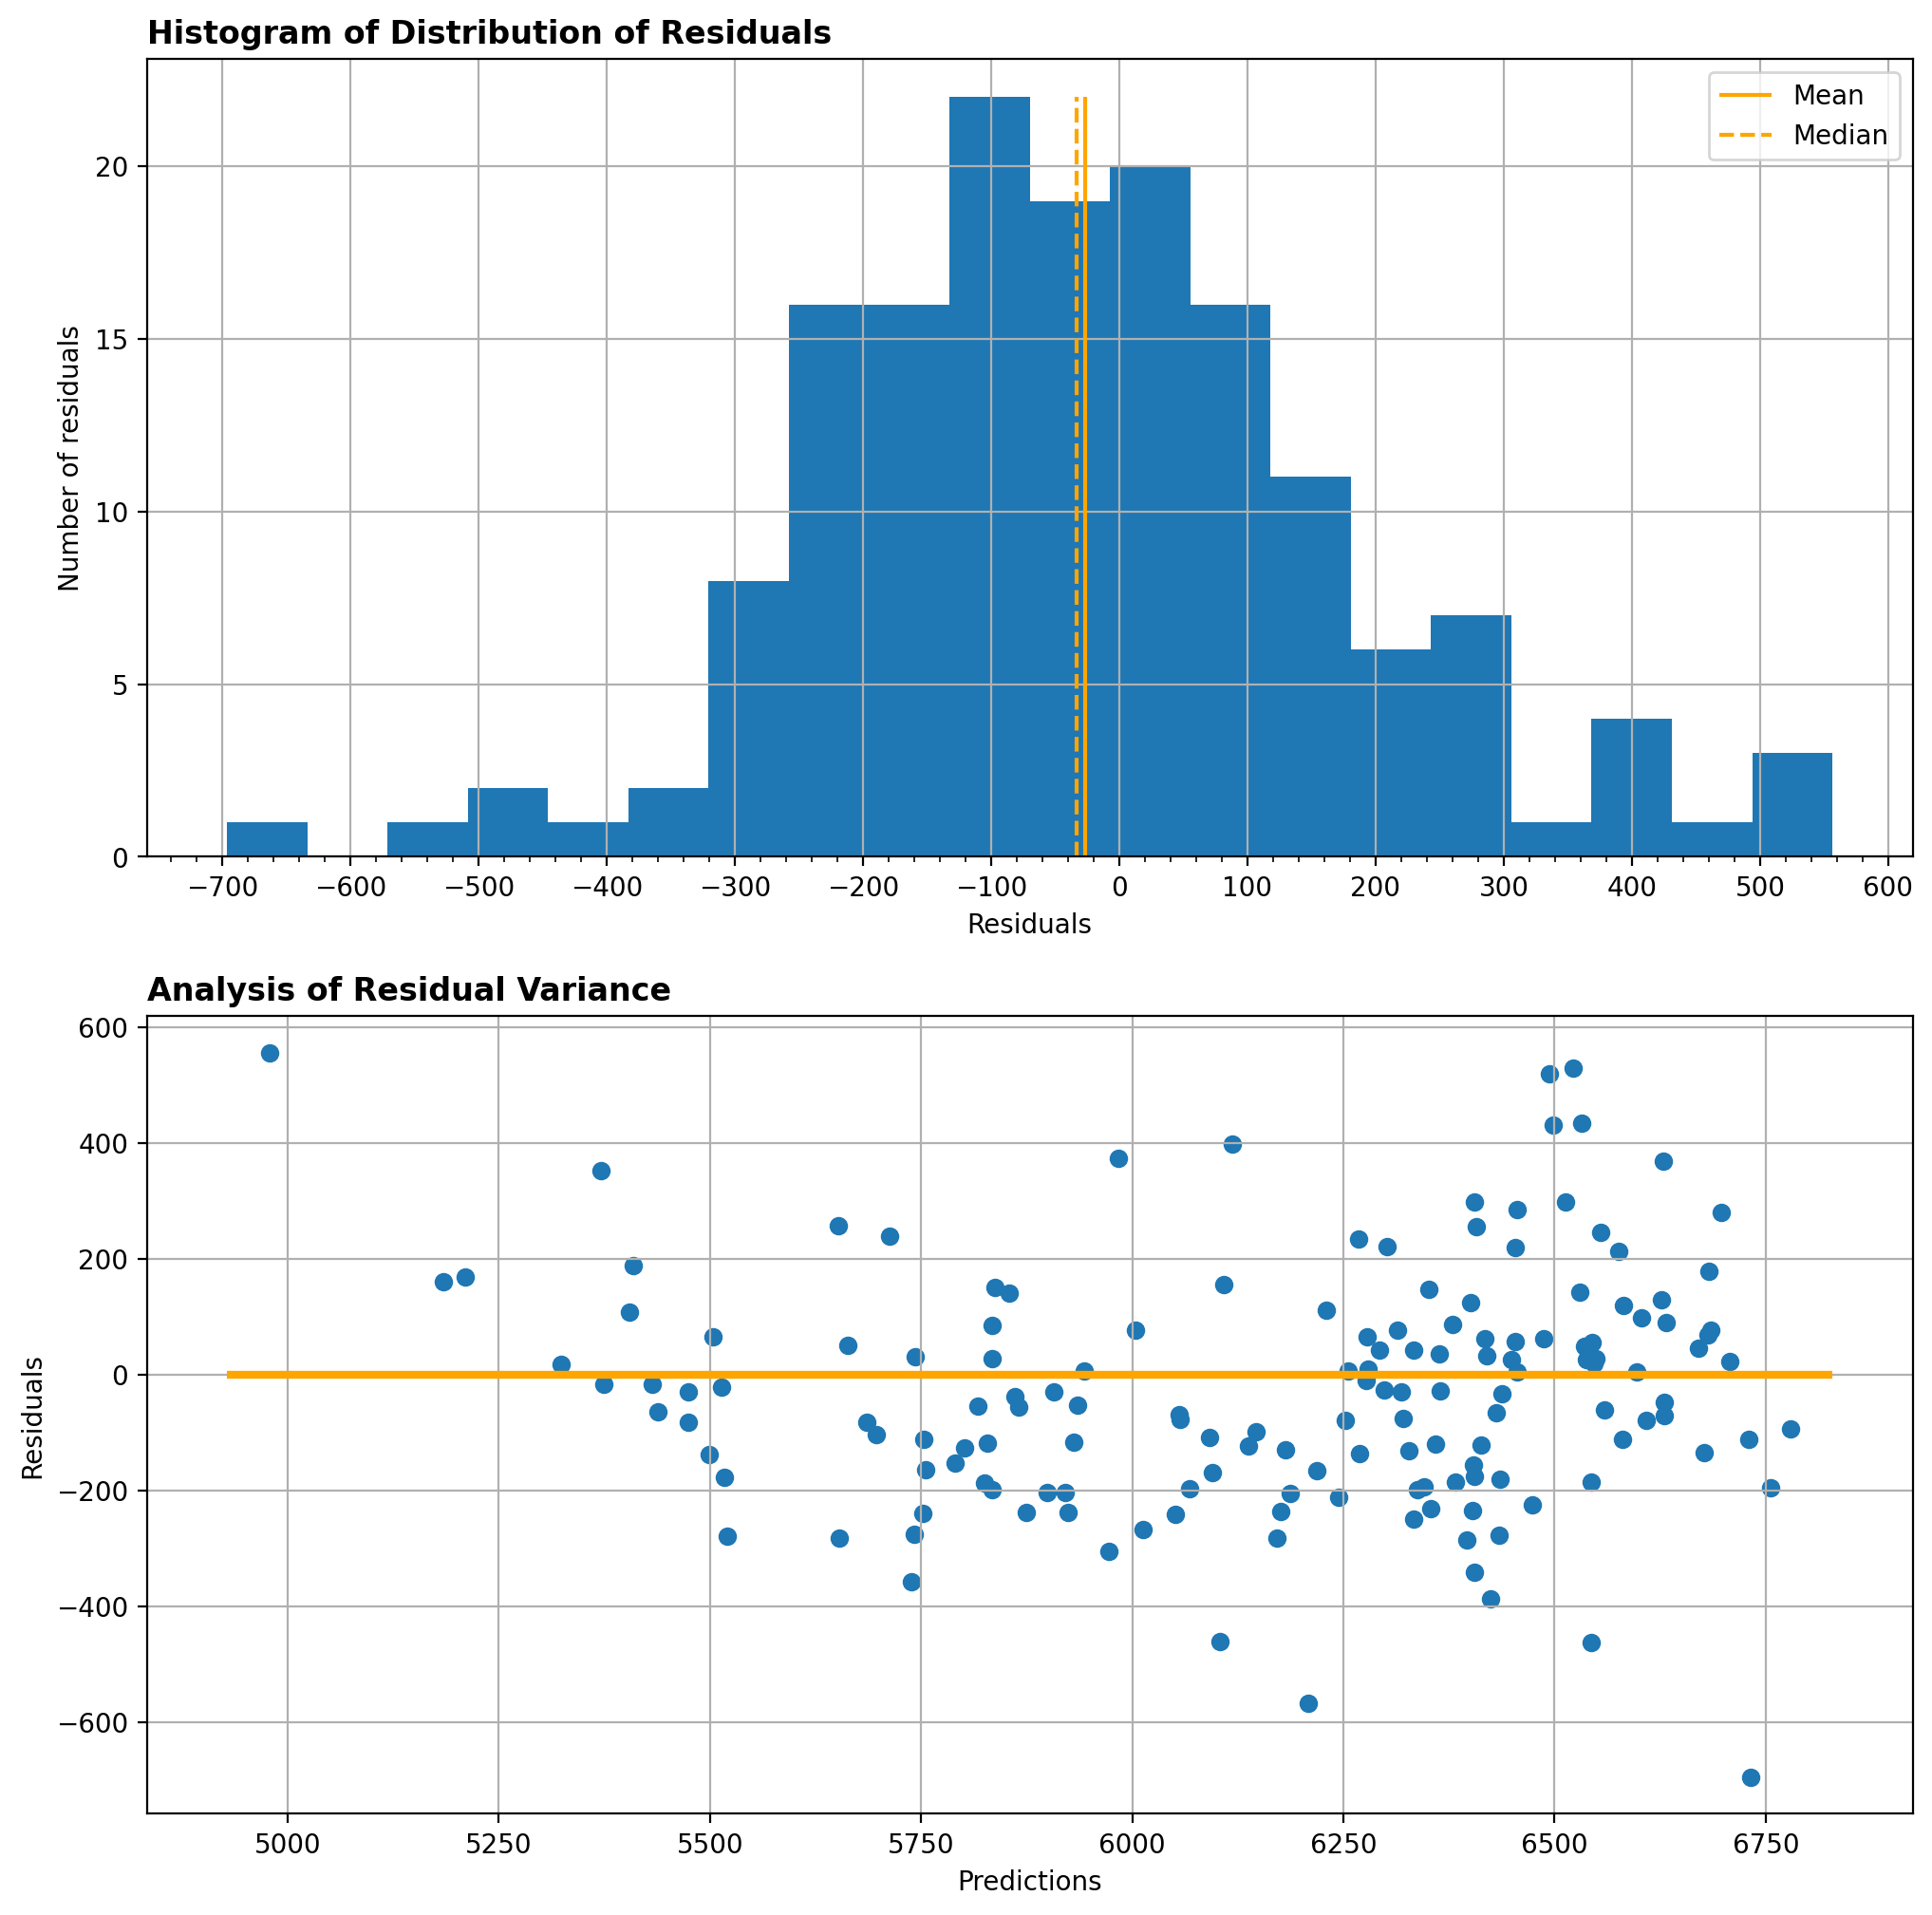

In [52]:
model_lr1  = LinearRegression()
model_lr1.fit(X_train, y_train)
predictions = model_lr1.predict(X_test)

print('\nLinear regression coefficients:')
for feature_number, feature_name in enumerate(X_test.columns):
    print(f'{feature_name:<32}: {model_lr1.coef_[feature_number]:+.5}')
print(f'w0{" "*30}: {model_lr1.intercept_:+.5}')

# Quality metrics
print('\nQuality metrics:')
rmse = root_mean_squared_error(y_test, predictions)
print(f'RMSE = {rmse:.2f}')
mae = mean_absolute_error(y_test, predictions)
print(f'MAE = {mae:.2f}')
r2 = r2_score(y_test, predictions)
print(f'R2 = {r2:.3f}')
print()

residual_analysis(y_test, predictions)

# Calculate confidence intervals
confidence_interval_95 = st.norm.interval(confidence=0.95, 
                                          loc=(predictions.mean()), 
                                          scale=st.sem(predictions))

# Add data to the table
lr_models_metrics.loc[len(lr_models_metrics.index)] = ['Model 1',
                                                       rmse.round(2),
                                                       mae.round(2),
                                                       r2.round(3),
                                                       confidence_interval_95[0].round(2),
                                                       confidence_interval_95[1].round(2)]

# Save model
lr_models.append(model_lr1)

**Summary**

- The model makes mistakes in predictions: by 207.7 kg of milk according to the RMSE metric and by 161.8 kg according to the MAE metric.
- The model’s prediction is more accurate than the average value of the target feature in 78.8% of cases.
- From the histogram of the distribution of residuals, we can conclude that the model often overestimates its predictions; its predictions are larger than the true values.
- The multimodality of the histogram of the distribution of residuals indicates that the model has not achieved maximum quality.
- The varince of the residuals is uneven, which means the model makes errors unpredictably, and its forecasts are unreliable.

The model needs to be improved.

### Model 2

In this iteration, we will transform the features that are nonlinearly related to the target feature `milk_yield`:
1. Let's convert `sugar_protein_ratio` into a categorical type, using the values 0.875 and 0.91 as category boundaries. The boundaries of the categories were selected based on the histogram of the feature distribution and scatterplots.
2. Let's introduce a new feature `energy_feed_unit_squared`.

In [53]:
# Create a data set copy
data_v2 = data.copy(deep=True)

In [54]:
# Transform sugar_protein_ratio
data_v2.loc[data_v2['sugar_protein_ratio'] < 0.875, 'SPR_cat'] = 'less_than_0.875'
data_v2.loc[(data_v2['sugar_protein_ratio'] >= 0.875) 
                 & (data_v2['sugar_protein_ratio'] <= 0.91), 'SPR_cat'] = 'from_0.875_to_0.91'
data_v2.loc[data_v2['sugar_protein_ratio'] > 0.91, 'SPR_cat'] = 'greater_than_0.91'
data_v2['SPR_cat'] = data_v2['SPR_cat'].astype('category')
data_v2['SPR_cat'].value_counts()

SPR_cat
greater_than_0.91     370
from_0.875_to_0.91    191
less_than_0.875        67
Name: count, dtype: int64

In [55]:
# Transform energy_feed_unit
data_v2['EFU_squared'] = data_v2['energy_feed_unit'].apply(lambda x: x**2)

In [56]:
cat_columns = ['breed', 'pasture_type','sire_breed', 'age', 'SPR_cat']
num_columns = ['energy_feed_unit', 'EFU_squared', 'crude_protein']

# Separate input and target features
X = data_v2.drop('milk_yield', axis=1)
y = data_v2['milk_yield']

# Train/Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=RANDOM_STATE)

# Scale numeric features with Standard Scaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[num_columns])
X_test_scaled = scaler.transform(X_test[num_columns])
    
# Encode categorical features with OneHotEncoder
encoder = OneHotEncoder(drop='first', sparse_output=False)
X_train_encoded = encoder.fit_transform(X_train[cat_columns])
X_test_encoded = encoder.transform(X_test[cat_columns])
encoder_columns = encoder.get_feature_names_out()
    
# Create new data set with encoded and scaled features
X_train_encoded = pd.DataFrame(X_train_encoded, columns=encoder_columns)
X_test_encoded = pd.DataFrame(X_test_encoded, columns=encoder_columns)
    
X_train_scaled = pd.DataFrame(X_train_scaled, columns=num_columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=num_columns)
    
X_train = pd.concat([X_train_encoded, X_train_scaled], axis=1)
X_test = pd.concat([X_test_encoded, X_test_scaled], axis=1)

X_train.head()

breed_Sovereign  pasture_type_plain  sire_breed_Sovereign  age_young  \
0              1.0                 0.0                   1.0        0.0   
1              1.0                 0.0                   1.0        1.0   
2              0.0                 1.0                   0.0        0.0   
3              0.0                 0.0                   0.0        0.0   
4              0.0                 1.0                   0.0        0.0   

   SPR_cat_greater_than_0.91  SPR_cat_less_than_0.875  energy_feed_unit  \
0                        1.0                      0.0          1.502378   
1                        0.0                      0.0         -1.557270   
2                        0.0                      0.0          0.125537   
3                        1.0                      0.0         -0.103937   
4                        0.0                      0.0         -1.098323   

   EFU_squared  crude_protein  
0     1.577968       1.079523  
1    -1.511438      -0.196920  
2     0.082269      -1.386085  
3    -0.150235       0.752230  
4    -1.102358       0.828598


Linear regression coefficients:
breed_Sovereign                 : +1.8937
pasture_type_plain              : -29.263
sire_breed_Sovereign            : -214.82
age_young                       : -268.57
SPR_cat_greater_than_0.91       : +384.29
SPR_cat_less_than_0.875         : +3.3631
energy_feed_unit                : -999.7
EFU_squared                     : +1144.0
crude_protein                   : +41.694
w0                              : +6070.4

Quality metrics:
RMSE = 192.89
MAE = 150.77
R2 = 0.817



true_y  predicted_y   residuals
582    5980  5919.724850   60.275150
592    6512  6522.258858  -10.258858
551    5392  5447.048978  -55.048978
214    5604  5627.002790  -23.002790
486    5667  5854.808158 -187.808158
236    6498  6344.364351  153.635649
454    6376  6310.966302   65.033698
78     6037  6429.727455 -392.727455
530    6618  6795.189189 -177.189189
146    5340  5636.659866 -296.659866

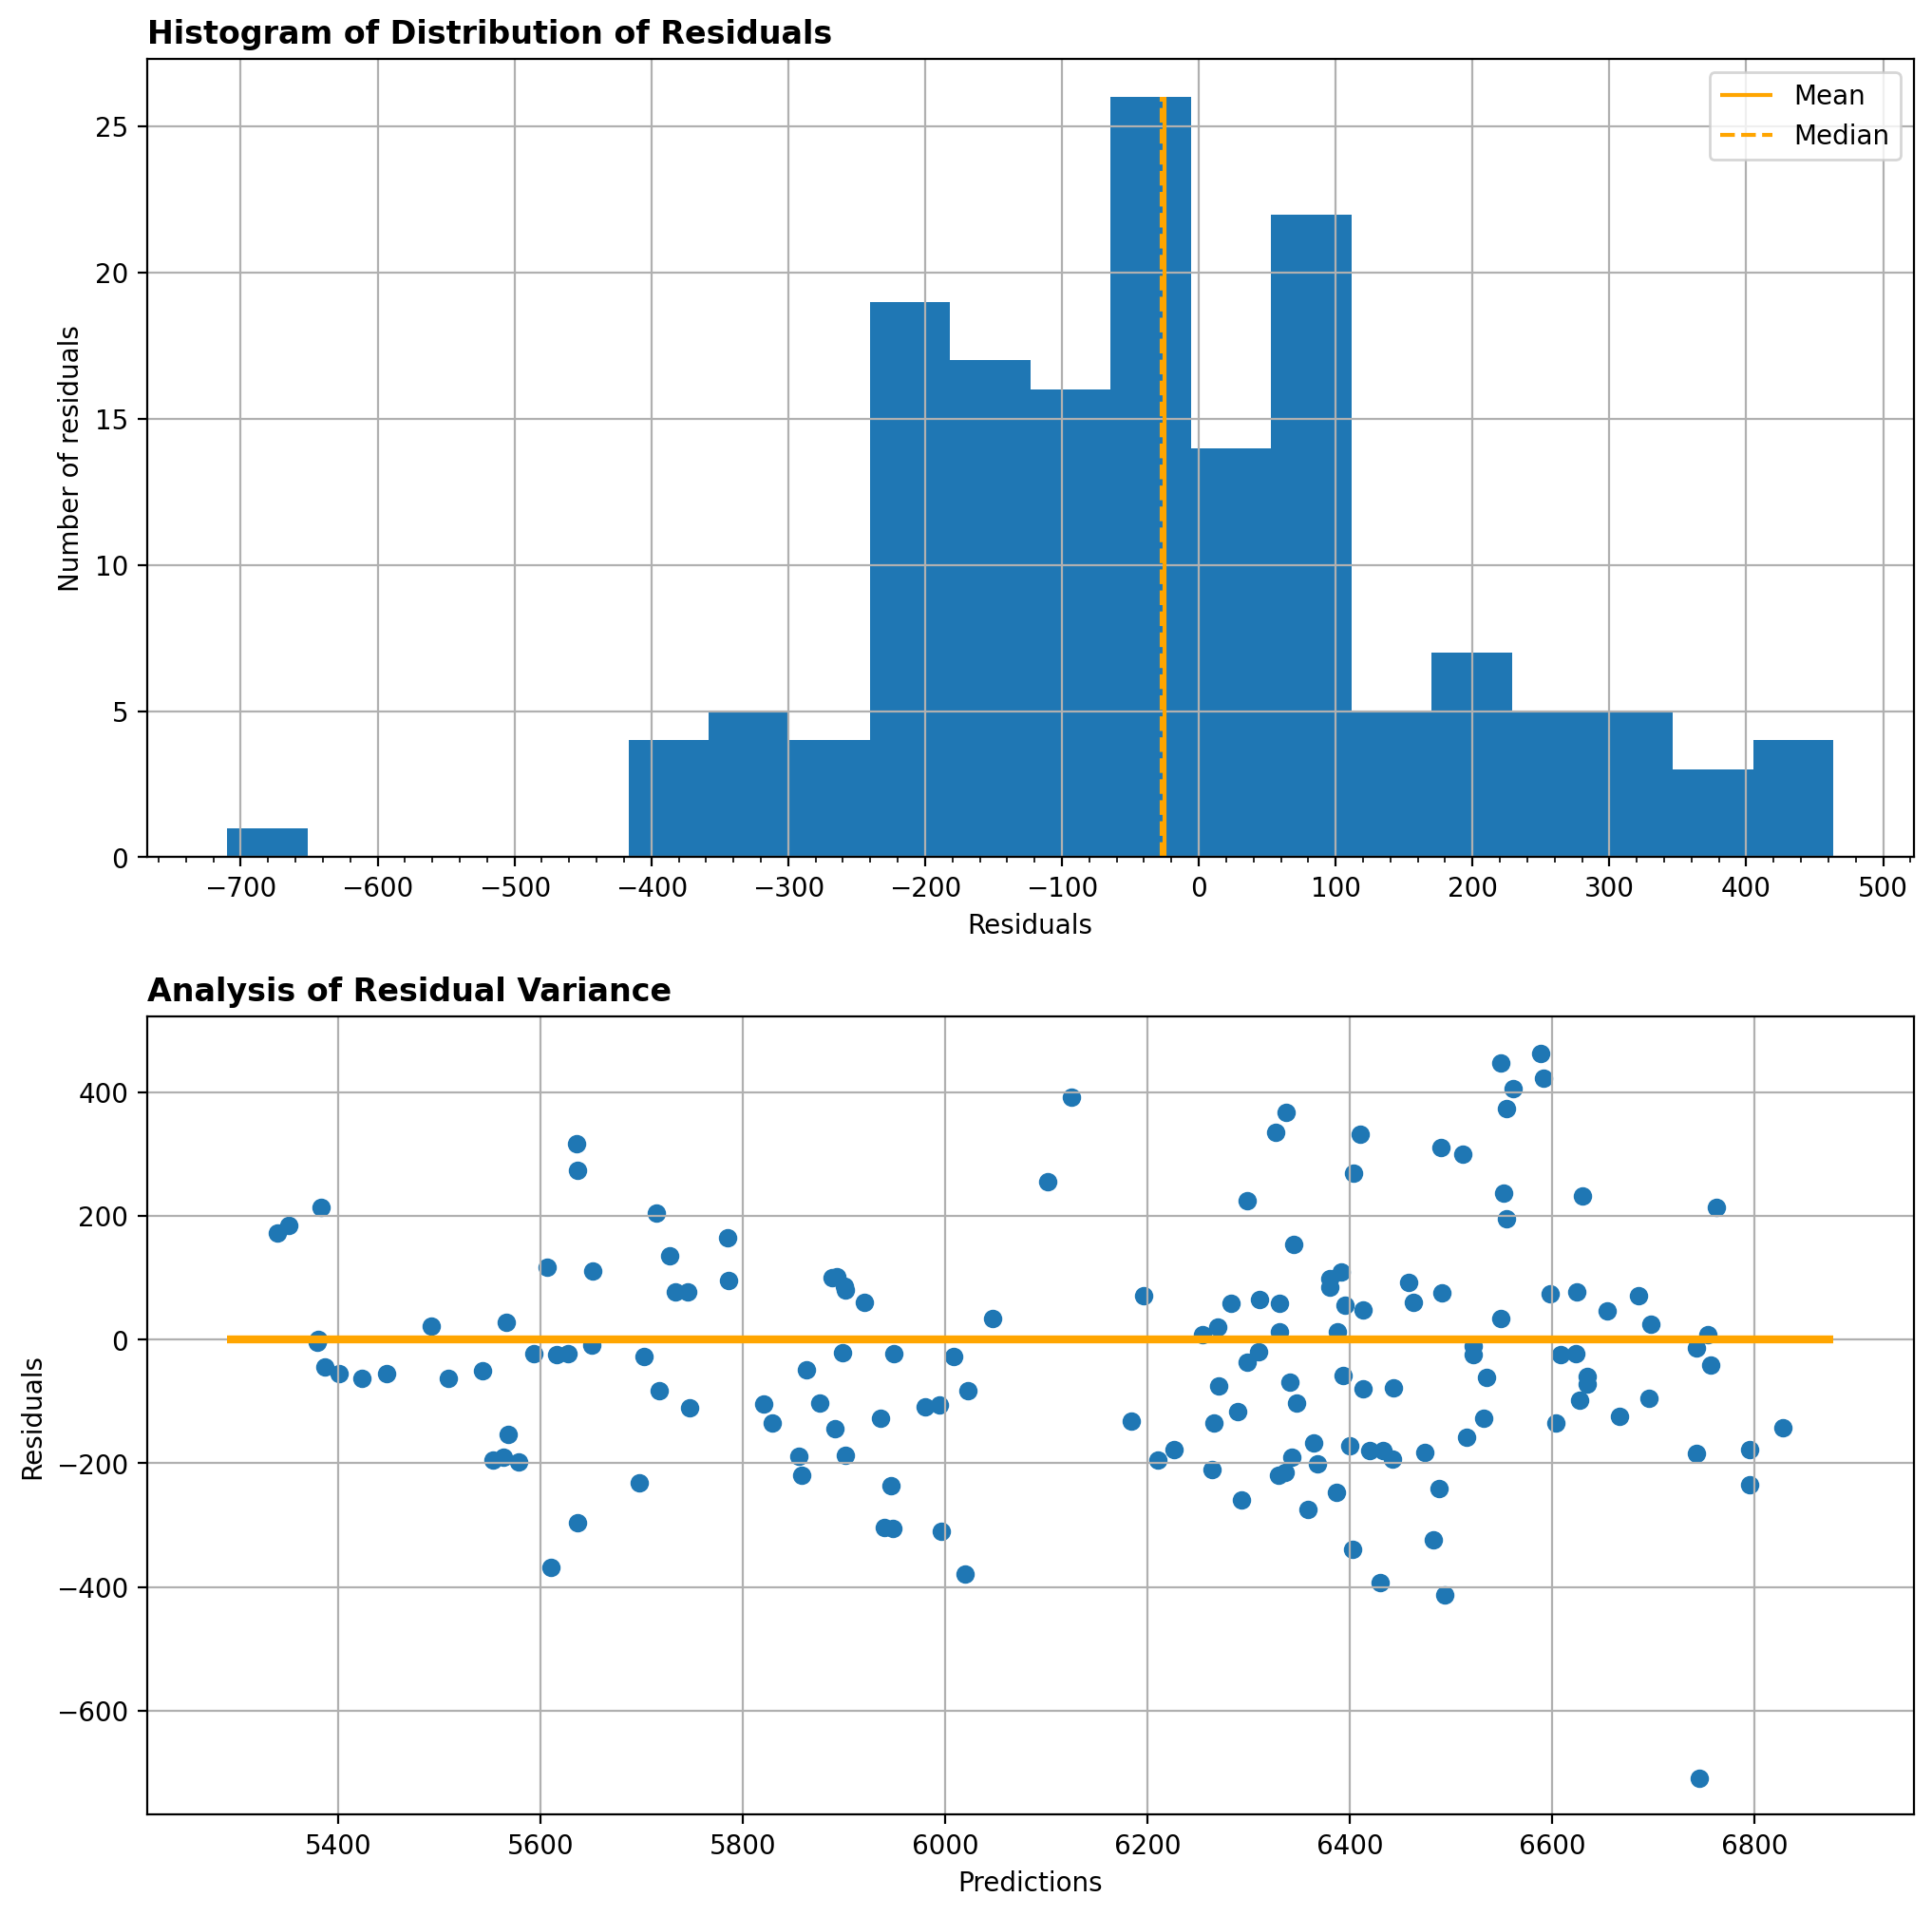

In [57]:
model_lr2  = LinearRegression()
model_lr2.fit(X_train, y_train)
predictions = model_lr2.predict(X_test)

print('\nLinear regression coefficients:')
for feature_number, feature_name in enumerate(X_test.columns):
    print(f'{feature_name:<32}: {model_lr2.coef_[feature_number]:+.5}')
print(f'w0{" "*30}: {model_lr2.intercept_:+.5}')

# Quality metrics
print('\nQuality metrics:')
rmse = root_mean_squared_error(y_test, predictions)
print(f'RMSE = {rmse:.2f}')
mae = mean_absolute_error(y_test, predictions)
print(f'MAE = {mae:.2f}')
r2 = r2_score(y_test, predictions)
print(f'R2 = {r2:.3f}')
print()

residual_analysis(y_test, predictions)

# Calculate confidence intervals
confidence_interval_95 = st.norm.interval(confidence=0.95, 
                                          loc=(predictions.mean()), 
                                          scale=st.sem(predictions))

# Add data to the table
lr_models_metrics.loc[len(lr_models_metrics.index)] = ['Model 2',
                                                       rmse.round(2),
                                                       mae.round(2),
                                                       r2.round(3),
                                                       confidence_interval_95[0].round(2),
                                                       confidence_interval_95[1].round(2)]

# Save model
lr_models.append(model_lr2)

**Summary**

- The model makes mistakes in predictions: by 192.9 kg of milk according to the RMSE metric and by 150.8 kg according to the MAE metric.
- The model’s prediction is more accurate than the average value of the target feature in 81.7% of cases.
- From the histogram of the distribution of residuals, we can conclude that the model often overestimates its predictions; its predictions are larger than the true values.
- The multimodality of the histogram of the distribution of residuals indicates that the model has not achieved maximum quality.
- The varince of the residuals is uneven, which means the model makes errors unpredictably, and its forecasts are unreliable.

The quality of the model has improved compared to the zero iteration, but the model still needs to be improved.

### Model 3

In this iteration, we will introduce a new feature into the model - sire's name.

In [58]:
# Create a data set copy
data_v3 = data_v2.copy(deep=True)

In [59]:
# Join datasets
data_v3 = data_v3.join(data_sires, how='inner')
print('Entries after the joining:', data_v3.shape[0])
data_v3.sample().T

Entries after the joining: 627


349
milk_yield                        6171
energy_feed_unit                  15.3
crude_protein                     1966
sugar_protein_ratio               0.94
breed                        Sovereign
pasture_type                     plain
sire_breed                   Sovereign
milk_fat                          3.73
milk_protein                     3.076
milk_taste                       tasty
age                                old
SPR_cat              greater_than_0.91
EFU_squared                     234.09
sire_name                       Буйный

In [60]:
cat_columns = ['breed', 'pasture_type','sire_breed', 'age', 'SPR_cat', 'sire_name']
num_columns = ['energy_feed_unit', 'EFU_squared', 'crude_protein']

# Separate input and target features
X = data_v3.drop('milk_yield', axis=1)
y = data_v3['milk_yield']

# Train/Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=RANDOM_STATE)

# Scale numeric features with Standard Scaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[num_columns])
X_test_scaled = scaler.transform(X_test[num_columns])
    
# Encode categorical features with OneHotEncoder
encoder = OneHotEncoder(drop='first', sparse_output=False)
X_train_encoded = encoder.fit_transform(X_train[cat_columns])
X_test_encoded = encoder.transform(X_test[cat_columns])
encoder_columns = encoder.get_feature_names_out()
    
# Create new data set with encoded and scaled features
X_train_encoded = pd.DataFrame(X_train_encoded, columns=encoder_columns)
X_test_encoded = pd.DataFrame(X_test_encoded, columns=encoder_columns)
    
X_train_scaled = pd.DataFrame(X_train_scaled, columns=num_columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=num_columns)
    
X_train = pd.concat([X_train_encoded, X_train_scaled], axis=1)
X_test = pd.concat([X_test_encoded, X_test_scaled], axis=1)

X_train.head()

breed_Sovereign  pasture_type_plain  sire_breed_Sovereign  age_young  \
0              0.0                 1.0                   1.0        0.0   
1              0.0                 0.0                   1.0        1.0   
2              0.0                 1.0                   0.0        0.0   
3              0.0                 0.0                   1.0        0.0   
4              1.0                 0.0                   1.0        0.0   

   SPR_cat_greater_than_0.91  SPR_cat_less_than_0.875  sire_name_Буйный  \
0                        1.0                      0.0               0.0   
1                        0.0                      0.0               0.0   
2                        0.0                      0.0               1.0   
3                        1.0                      0.0               1.0   
4                        1.0                      0.0               0.0   

   sire_name_Геркулес  sire_name_Соловчик  energy_feed_unit  EFU_squared  \
0                 0.0                 1.0          1.170171     1.201426   
1                 0.0                 0.0         -1.297146    -1.282626   
2                 0.0                 0.0          0.090720     0.047198   
3                 0.0                 0.0          0.630446     0.611196   
4                 1.0                 0.0          0.784653     0.777156   

   crude_protein  
0       2.043510  
1       0.120002  
2      -1.379681  
3       0.397118  
4       0.130870


Linear regression coefficients:
breed_Sovereign                 : +25.15
pasture_type_plain              : -33.489
sire_breed_Sovereign            : -209.05
age_young                       : -263.89
SPR_cat_greater_than_0.91       : +403.34
SPR_cat_less_than_0.875         : +18.521
sire_name_Буйный                : -6.2072
sire_name_Геркулес              : -21.262
sire_name_Соловчик              : -1.8929
energy_feed_unit                : -877.42
EFU_squared                     : +1017.9
crude_protein                   : +41.694
w0                              : +6053.3

Quality metrics:
RMSE = 188.42
MAE = 146.78
R2 = 0.840



true_y  predicted_y   residuals
582    5980  5905.798243   74.201757
592    6512  6530.967379  -18.967379
552    6508  6494.480687   13.519313
215    5795  5846.223796  -51.223796
487    6005  6287.718205 -282.718205
237    5884  5723.684547  160.315453
455    6322  6471.141167 -149.141167
79     5813  5841.580483  -28.580483
531    5836  5776.806618   59.193382
147    5672  5658.089755   13.910245

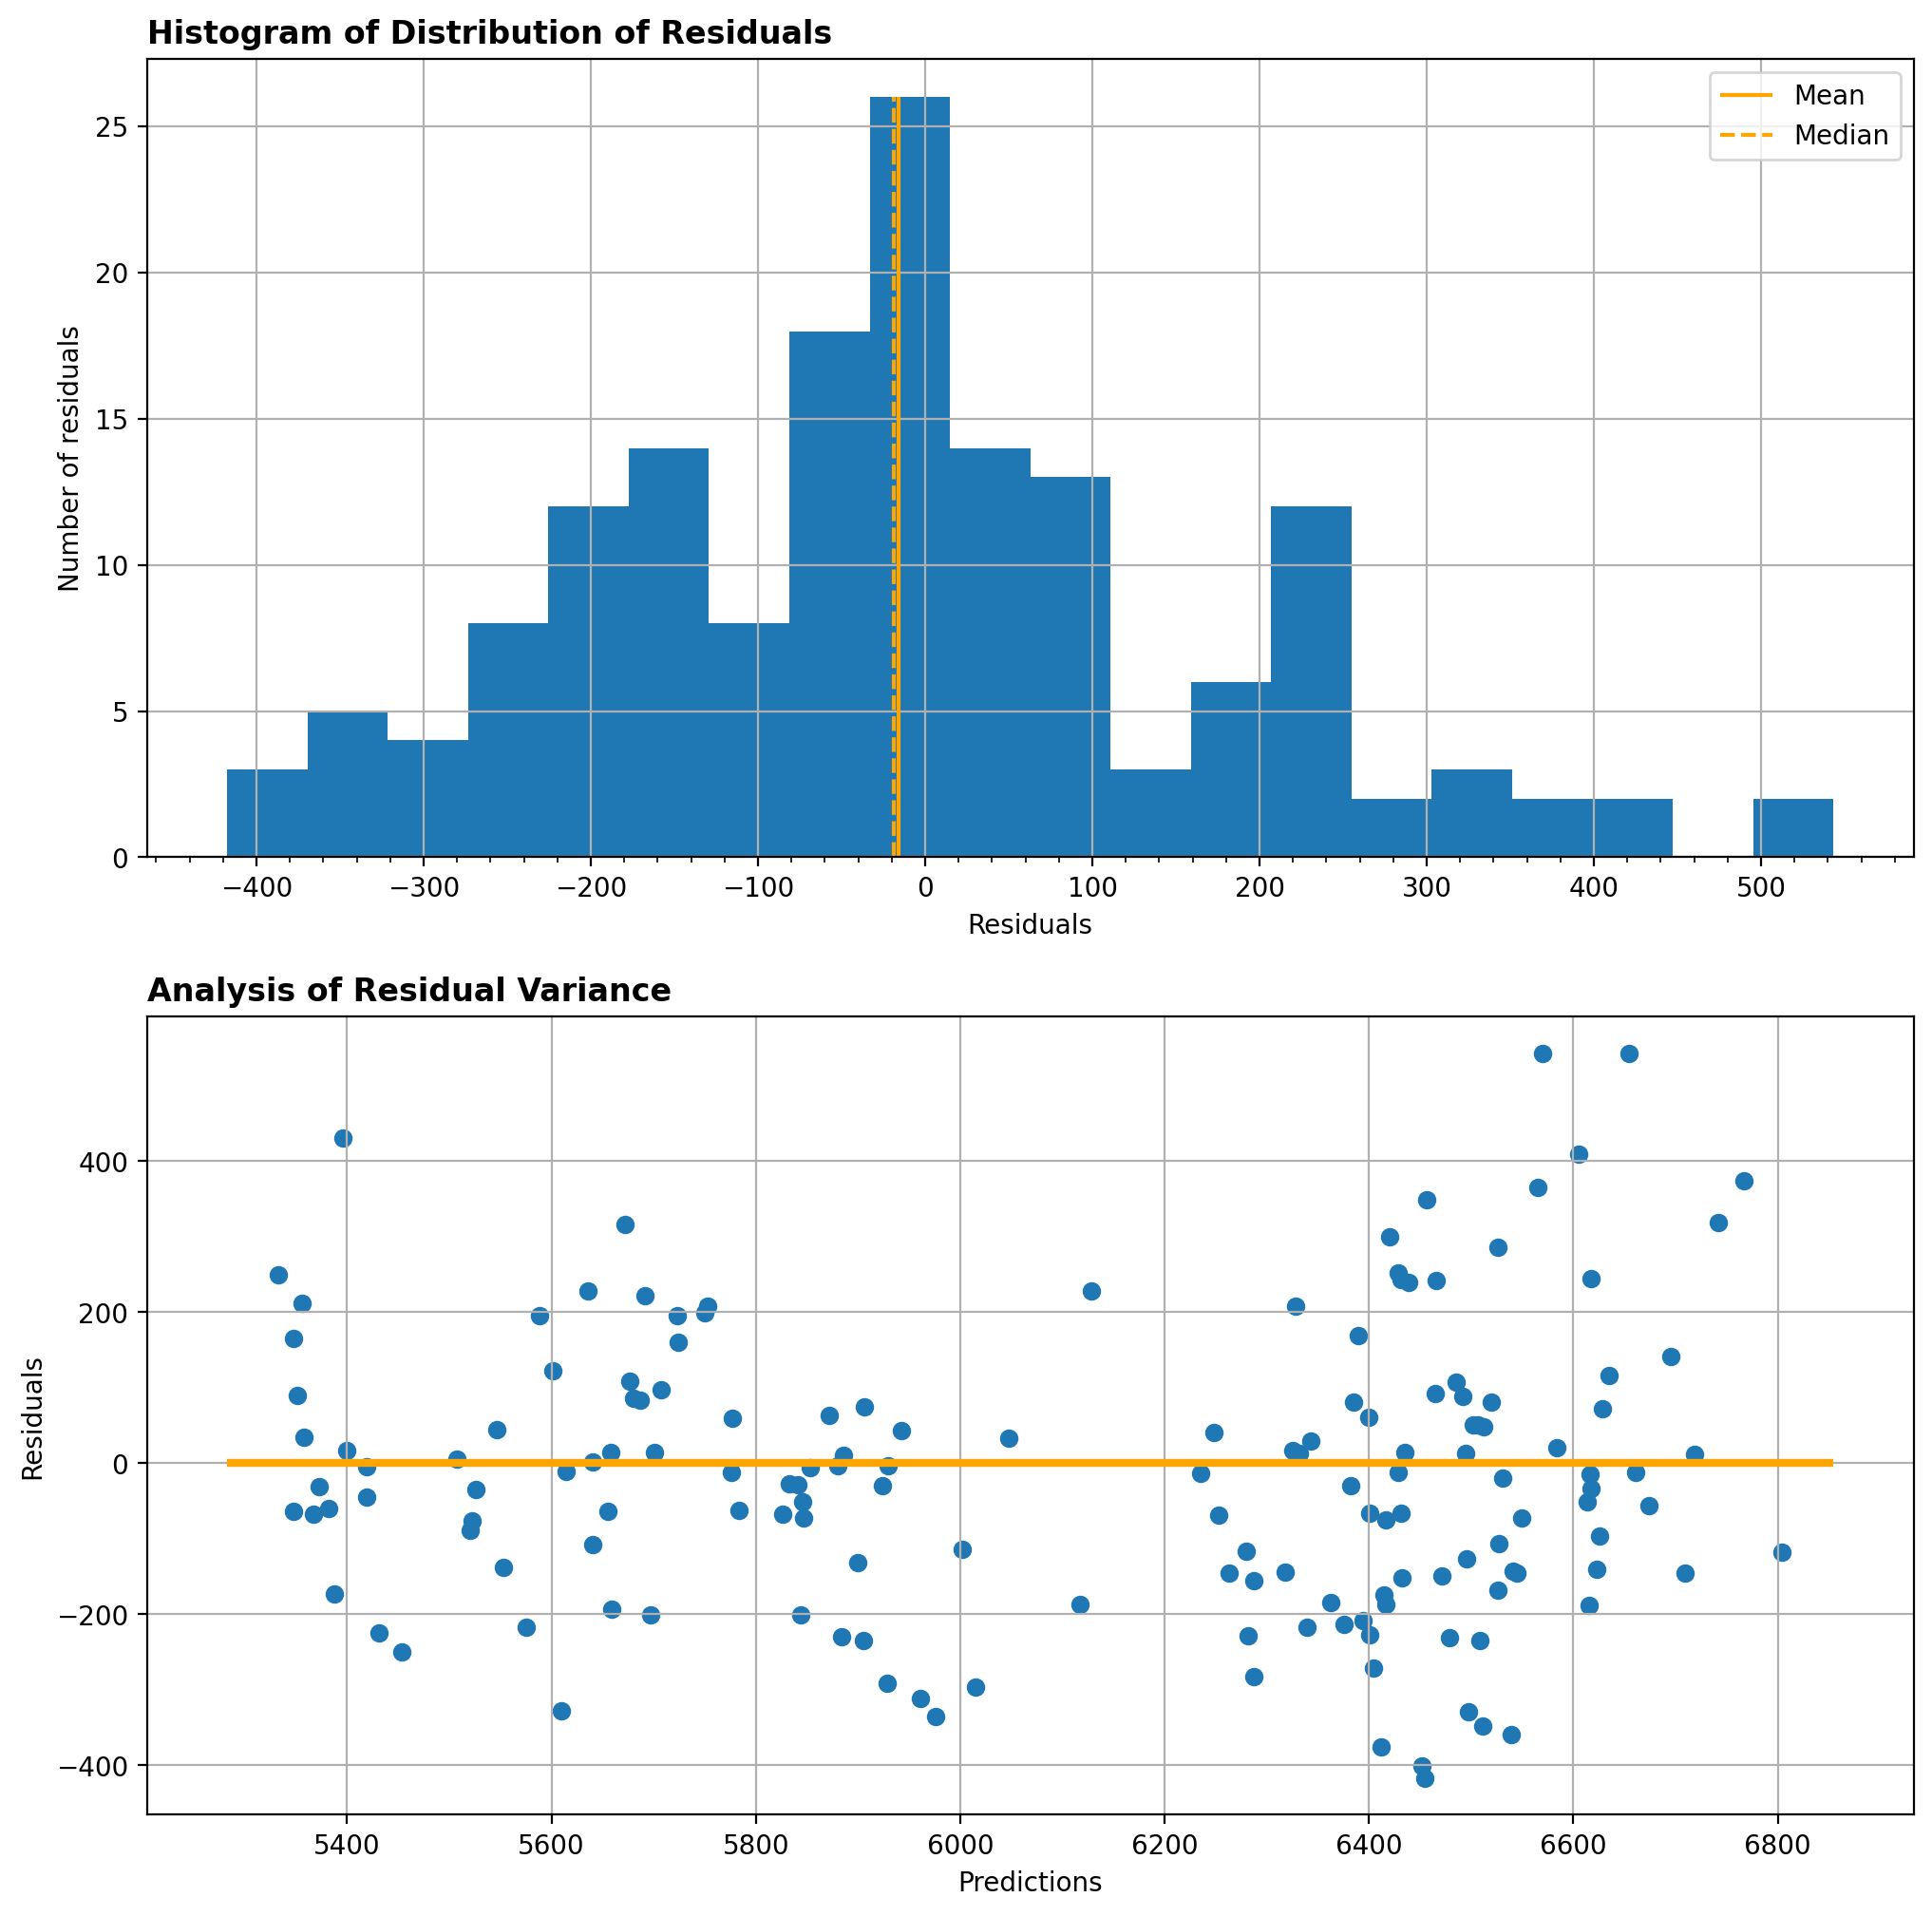

In [61]:
model_lr3  = LinearRegression()
model_lr3.fit(X_train, y_train)
predictions = model_lr3.predict(X_test)

print('\nLinear regression coefficients:')
for feature_number, feature_name in enumerate(X_test.columns):
    print(f'{feature_name:<32}: {model_lr3.coef_[feature_number]:+.5}')
print(f'w0{" "*30}: {model_lr3.intercept_:+.5}')

# Quality metrics
print('\nQuality metrics:')
rmse = root_mean_squared_error(y_test, predictions)
print(f'RMSE = {rmse:.2f}')
mae = mean_absolute_error(y_test, predictions)
print(f'MAE = {mae:.2f}')
r2 = r2_score(y_test, predictions)
print(f'R2 = {r2:.3f}')
print()

residual_analysis(y_test, predictions)

# Calculate confidence intervals
confidence_interval_95 = st.norm.interval(confidence=0.95, 
                                          loc=(predictions.mean()), 
                                          scale=st.sem(predictions))

# Add data to the table
lr_models_metrics.loc[len(lr_models_metrics.index)] = ['Model 3',
                                                       rmse.round(2),
                                                       mae.round(2),
                                                       r2.round(3),
                                                       confidence_interval_95[0].round(2),
                                                       confidence_interval_95[1].round(2)]

# Save model
lr_models.append(model_lr3)

**Summary**

- The model makes mistakes in predictions: by 188.4 kg of milk according to the RMSE metric and by 146.8 kg according to the MAE metric.
- The model’s prediction is more accurate than the average value of the target feature in 84% of cases.
- From the histogram of the distribution of residuals, we can conclude that the model often overestimates its predictions; its predictions are larger than the true values.
- The multimodality of the histogram of the distribution of residuals indicates that the model has not achieved maximum quality.
- The varince of the residuals is more uneven than before.

The quality of the model has imroved. There is reason to believe that the quality of the model cannot be improved further due to the quality of the input data or without using advanced models.

### Model comparison

In [62]:
# Show all the models and their parameters
lr_models_metrics

Model    rmse     mae     r2  confidence_interval_95_a  \
0  Model 1  207.72  161.78  0.788                   6106.07   
1  Model 2  192.89  150.77  0.817                   6103.11   
2  Model 3  188.42  146.78  0.840                   6044.02   

   confidence_interval_95_b  
0                   6230.77  
1                   6230.45  
2                   6179.99

The last model shows the best quality metrics. There is a 95% chance that the confidence interval [6044, 6180] contains the true mean milk yield.

### EcoFarm cows `milk_yield` prediction

There are no feed parameters in the EcoFarm data set. The purchased cows will receive a diet developed by technologists for the cows of the herd. According to the customer’s wishes, we will take the average values of feed parameters taking into account the age of the cows and add 5% to them.

In [63]:
# Add columns with feed parameters
columns_to_add = ['energy_feed_unit','crude_protein','sugar_protein_ratio']
for column in columns_to_add:
    data_purchase.loc[data_purchase['age']=='young',
                  column] = data.loc[data['age']=='young'][column].mean()*1.05
    data_purchase.loc[data_purchase['age']=='old',
                  column] = data.loc[data['age']=='old'][column].mean()*1.05

# Transform sugar_protein_ratio
data_purchase.loc[data_purchase['sugar_protein_ratio'] < 0.875, 'SPR_cat'] = 'less_than_0.875'
data_purchase.loc[(data_purchase['sugar_protein_ratio'] >= 0.875) 
                 & (data_purchase['sugar_protein_ratio'] <= 0.91), 'SPR_cat'] = 'from_0.875_to_0.91'
data_purchase.loc[data_purchase['sugar_protein_ratio'] > 0.91, 'SPR_cat'] = 'greater_than_0.91'
data_purchase['SPR_cat'] = data_purchase['SPR_cat'].astype('category')

# Add energy_feed_unit_squared
data_purchase['EFU_squared'] = data_purchase['energy_feed_unit'].apply(lambda x: x**2)

In [64]:
data_purchase_scaled = scaler.transform(data_purchase[num_columns])
data_purchase_encoded = encoder.transform(data_purchase[cat_columns])
    
encoder_columns = encoder.get_feature_names_out()
    
data_purchase_encoded = pd.DataFrame(data_purchase_encoded, columns=encoder_columns)
data_purchase_scaled = pd.DataFrame(data_purchase_scaled, columns=num_columns)
    
data_purchase_model = pd.concat([data_purchase_encoded, data_purchase_scaled], axis=1)
    
print('data_purchase after scaling and encoding:')
display(data_purchase_model.head())

data_purchase after scaling and encoding:


breed_Sovereign  pasture_type_plain  sire_breed_Sovereign  age_young  \
0              0.0                 0.0                   0.0        0.0   
1              0.0                 1.0                   1.0        1.0   
2              1.0                 1.0                   1.0        0.0   
3              1.0                 0.0                   0.0        0.0   
4              1.0                 1.0                   0.0        0.0   

   SPR_cat_greater_than_0.91  SPR_cat_less_than_0.875  sire_name_Буйный  \
0                        1.0                      0.0               0.0   
1                        1.0                      0.0               1.0   
2                        1.0                      0.0               0.0   
3                        1.0                      0.0               1.0   
4                        1.0                      0.0               1.0   

   sire_name_Геркулес  sire_name_Соловчик  energy_feed_unit  EFU_squared  \
0                 1.0                 0.0          0.804346     0.798504   
1                 0.0                 0.0         -0.733589    -0.763553   
2                 0.0                 0.0          0.804346     0.798504   
3                 0.0                 0.0          0.804346     0.798504   
4                 0.0                 0.0          0.804346     0.798504   

   crude_protein  
0       0.655344  
1      -0.138056  
2       0.655344  
3       0.655344  
4       0.655344

In [65]:
# Make predictions using Model 3
predictions = model_lr3.predict(data_purchase_model)

# Add predicted mil_yield to EcoFarm dataset
data_purchase['milk_yield'] = predictions.round()

# Count cows that produce 6000 or more kg milk
len(data_purchase[data_purchase['milk_yield']>=6000])

16

According to the predicted `milk_yield`, 16 cows out of 20 satisfy customer's requirements. To predict the taste of milk, we need another model - logistic regression.

## Machine learning models for `milk_taste` prediction

As our target feature `milk_taste` is a binary categorical feature, we are solving binary classification problem.

In [66]:
# Add feature milk_taste_bool
data.loc[data['milk_taste'] == 'tasty', 'milk_taste_bool'] = True
data.loc[data['milk_taste'] == 'not tasty', 'milk_taste_bool'] = False
data['milk_taste_bool'] = data['milk_taste_bool'].astype('bool')

To build a model for the target feature `milk_taste_bool`, we will use all the features, since nutrition, habitat, heredity, milk parameters, age - everything can influence the taste of milk.

In [67]:
cat_columns = ['breed', 'pasture_type', 
               'sire_breed', 'age']

num_columns = ['energy_feed_unit', 'sugar_protein_ratio', 
               'crude_protein', 'milk_fat', 'milk_protein']

# Separate input and target features
X = data.drop(['milk_taste_bool','milk_taste'], axis=1)
y = data['milk_taste_bool']

# Train/Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=RANDOM_STATE)

# Scale numeric features with Standard Scaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[num_columns])
X_test_scaled = scaler.transform(X_test[num_columns])
    
# Encode categorical features with OneHotEncoder
encoder = OneHotEncoder(drop='first', sparse_output=False)
X_train_encoded = encoder.fit_transform(X_train[cat_columns])
X_test_encoded = encoder.transform(X_test[cat_columns])
encoder_columns = encoder.get_feature_names_out()
    
# Create new data set with encoded and scaled features
X_train_encoded = pd.DataFrame(X_train_encoded, columns=encoder_columns)
X_test_encoded = pd.DataFrame(X_test_encoded, columns=encoder_columns)
    
X_train_scaled = pd.DataFrame(X_train_scaled, columns=num_columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=num_columns)
    
X_train = pd.concat([X_train_encoded, X_train_scaled], axis=1)
X_test = pd.concat([X_test_encoded, X_test_scaled], axis=1)

X_train.head()

breed_Sovereign  pasture_type_plain  sire_breed_Sovereign  age_young  \
0              1.0                 0.0                   1.0        0.0   
1              1.0                 0.0                   1.0        1.0   
2              0.0                 1.0                   0.0        0.0   
3              0.0                 0.0                   0.0        0.0   
4              0.0                 1.0                   0.0        0.0   

   energy_feed_unit  sugar_protein_ratio  crude_protein  milk_fat  \
0          1.502378             0.837130       1.079523  0.562532   
1         -1.557270            -0.703660      -0.196920 -1.601817   
2          0.125537            -1.011818      -1.386085 -2.563750   
3         -0.103937             0.837130       0.752230  0.081565   
4         -1.098323            -0.703660       0.828598  0.201807   

   milk_protein  
0     -0.679069  
1     -1.452568  
2      1.254677  
3      1.254677  
4      0.094429

Odds chances:
breed_Sovereign         : +1.091924
pasture_type_plain      : +0.594474
sire_breed_Sovereign    : +1.146060
age_young               : +0.910821
energy_feed_unit        : +1.391597
sugar_protein_ratio     : +1.228002
crude_protein           : +1.068220
milk_fat                : +0.867491
milk_protein            : +1.285640

True/Predicted values:


true_y  predicted_y
582    True         True
592    True         True
551    True         True
214   False        False
486    True         True
236   False         True
454    True         True
78     True         True
530    True         True
146   False        False

Quality metrics:
Accuracy = 0.61
Recall = 0.84
Precision = 0.61



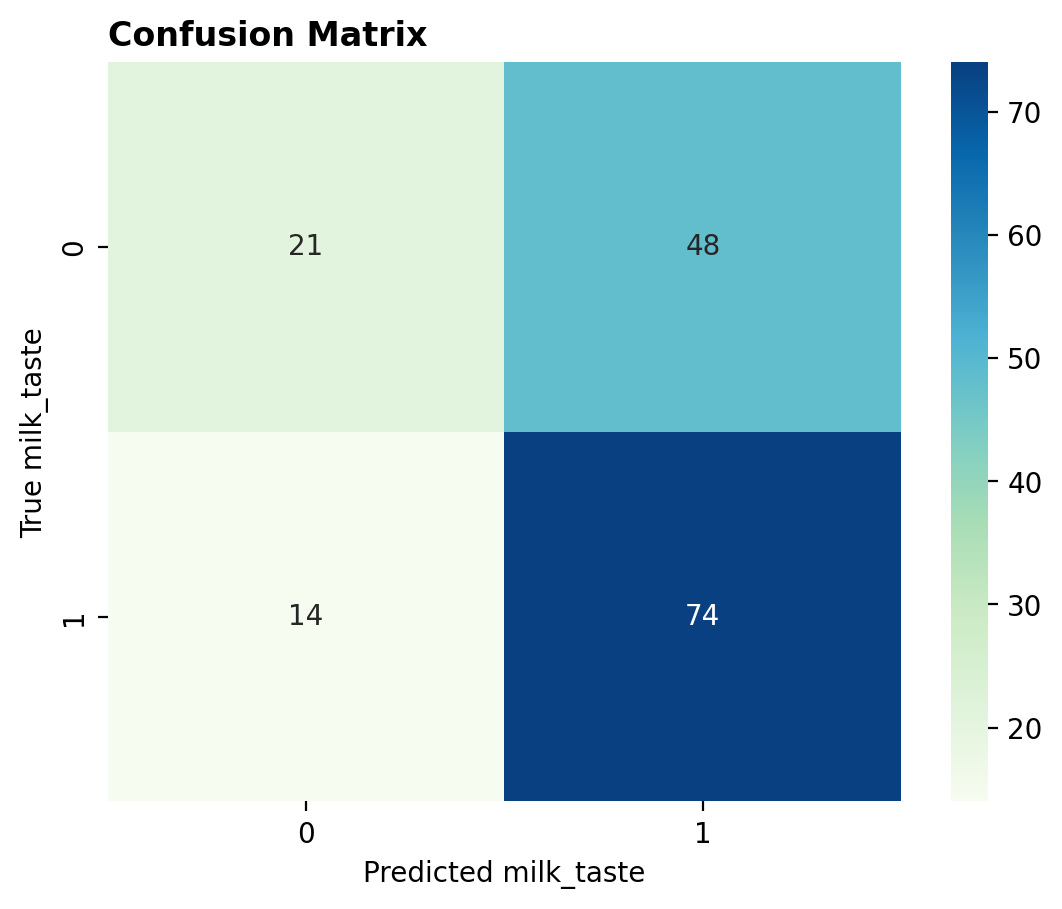

In [68]:
model_clf = LogisticRegression()
model_clf.fit(X_train, y_train)

predictions = model_clf.predict(X_test)
y_proba = model_clf.predict_proba(X_test)

print('Odds chances:')
for feature_number, feature_name in enumerate(X_test.columns):
    exp_weight = math.exp(model_clf.coef_[0, feature_number])
    print(f"{feature_name:<24}: {exp_weight:+.6f}")
print()
    
true_predicted = pd.DataFrame({'true_y': y_test, 'predicted_y': predictions})
print('True/Predicted values:')
display(true_predicted.head(10))

print('Quality metrics:')
accuracy = accuracy_score(y_test, predictions)
print(f'Accuracy = {accuracy:.2f}')
recall = recall_score(y_test, predictions)
print(f'Recall = {recall:.2f}')
precision = precision_score(y_test, predictions)
print(f'Precision = {precision:.2f}')
print()

# Comfusion Matrix
fig, ax = plt.subplots()
error_matrix = confusion_matrix(y_test, predictions)
sns.heatmap(error_matrix, annot=True, cmap='GnBu')
ax.set_title('Confusion Matrix',
             loc='left',
             fontweight='semibold')
plt.ylabel('True milk_taste')
plt.xlabel('Predicted milk_taste')
plt.show()

### Setting the classification threshold

According to the conditions of the task, we need the milk taste to necessarily correspond to the strict standard of the customer. This means that we need to minimize errors of the first type (false-positive predictions) - when the model predicted that milk would be tasty, but in fact it turned out to be tasteless. For this purpose, we need to maximize the precision metric.

In [69]:
# Create a variable to store classification models
clf_models = []

# Create a table to store the parameters of the models
clf_models_metrics = pd.DataFrame({'class_weight_true': [],
                                   'precision': [],
                                   'accuracy': [],
                                   'good_cows_count': []})

clf_models_metrics['class_weight_true'] = np.linspace(0.20, 0.35, num=15, endpoint=False)

# Calculate precision for different weights
for weight in clf_models_metrics['class_weight_true']:
    model_clf = LogisticRegression(class_weight={True: weight,
                                                 False: 1 - weight})
    model_clf.fit(X_train, y_train)
    
    predictions = model_clf.predict(X_test)
    
    clf_models_metrics.loc[clf_models_metrics['class_weight_true'] == weight,
                           'precision'] = precision_score(y_test, predictions, zero_division=0.0)
    
    # рассчитаем метрику accuracy
    clf_models_metrics.loc[clf_models_metrics['class_weight_true'] == weight,
                           'accuracy'] = accuracy_score(y_test, predictions)
    
    # сохраним модель в перемунную с моделями
    clf_models.append(model_clf)

clf_models_metrics[['class_weight_true','precision']].T

0     1         2         3         4         5   \
class_weight_true  0.200000  0.21  0.220000  0.230000  0.240000  0.250000   
precision          0.857143  0.80  0.866667  0.888889  0.904762  0.833333   

                         6        7         8         9     10    11       12  \
class_weight_true  0.260000  0.27000  0.280000  0.290000  0.30  0.31  0.32000   
precision          0.827586  0.78125  0.710526  0.731707  0.75  0.75  0.72549   

                         13        14  
class_weight_true  0.330000  0.340000  
precision          0.698113  0.733333

Odds chances:
breed_Sovereign         : +1.107258
pasture_type_plain      : +0.584557
sire_breed_Sovereign    : +1.216022
age_young               : +0.936559
energy_feed_unit        : +1.439734
sugar_protein_ratio     : +1.253063
crude_protein           : +1.078232
milk_fat                : +0.827065
milk_protein            : +1.292687

True/Predicted values:


true_y  predicted_y
582    True        False
592    True         True
551    True        False
214   False        False
486    True        False
236   False        False
454    True        False
78     True        False
530    True        False
146   False        False


Quality metrics:
Accuracy = 0.55
Recall = 0.22
Precision = 0.90



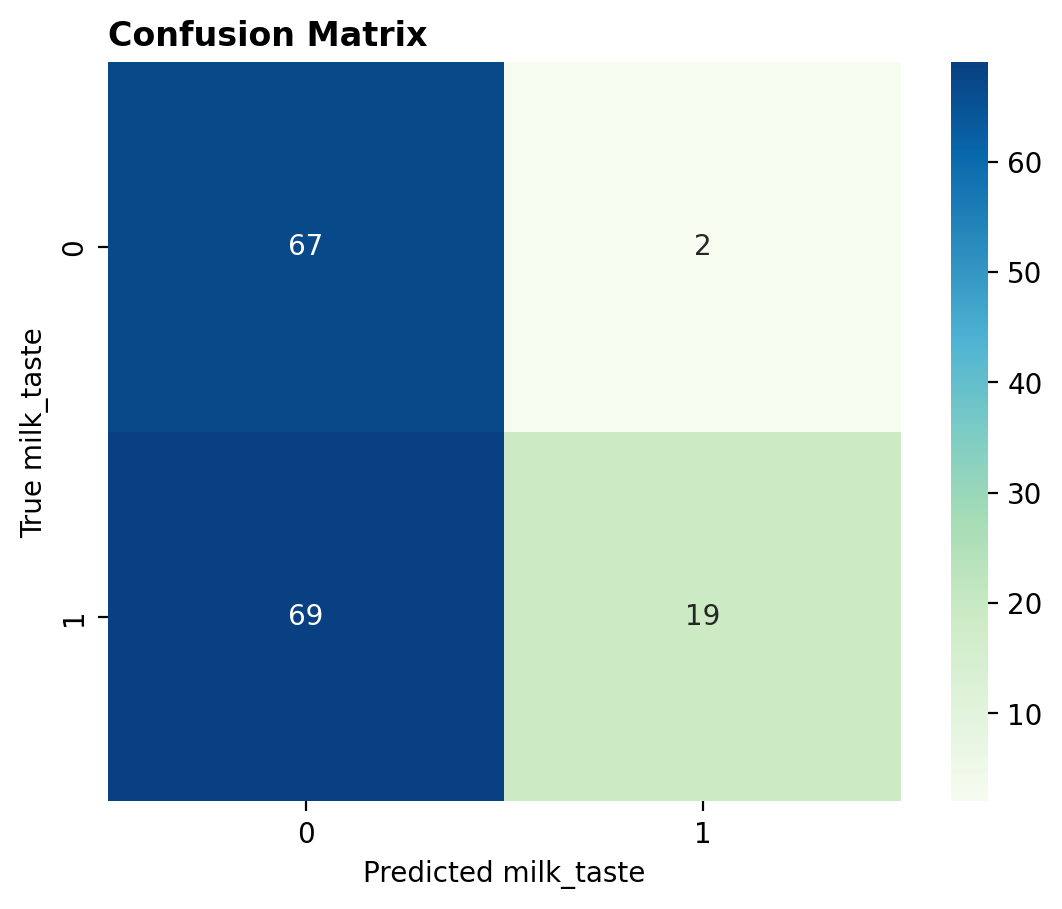

In [70]:
weight = clf_models_metrics.loc[clf_models_metrics['precision'].idxmax(), 'class_weight_true']

# Create a model with weights for maximum precision
model_clf_max = LogisticRegression(class_weight={True: weight, False: 1-weight})
model_clf_max.fit(X_train, y_train)
    
predictions = model_clf_max.predict(X_test)

print('Odds chances:')
for feature_number, feature_name in enumerate(X_test.columns):
    exp_weight = math.exp(model_clf_max.coef_[0, feature_number])
    print(f"{feature_name:<24}: {exp_weight:+.6f}")

true_predicted = pd.DataFrame({'true_y': y_test, 'predicted_y': predictions})
print('\nTrue/Predicted values:')
display(true_predicted.head(10))

print('\nQuality metrics:')
accuracy = accuracy_score(y_test, predictions)
print(f'Accuracy = {accuracy:.2f}')
recall = recall_score(y_test, predictions)
print(f'Recall = {recall:.2f}')
precision = precision_score(y_test, predictions)
print(f'Precision = {precision:.2f}')
print()

# Confusion matrix
fig, ax = plt.subplots()
error_matrix = confusion_matrix(y_test, predictions)
sns.heatmap(error_matrix, annot=True, cmap='GnBu')
ax.set_title('Confusion Matrix',
              loc='left',
              fontweight='semibold')
plt.ylabel('True milk_taste')
plt.xlabel('Predicted milk_taste')
plt.show()

**Summary**

This model allows us to choose a cow with tasty milk with 90% confidence. At the same time, we have significantly increased the likelihood of a second type error: we mistakenly classify cows with tasty milk as “not tasty milk”, that is, we miss the opportunity to buy a cow. Of the total number of cows with tasty milk, only 22% will be choosen by this model.

Most likely, such strict selection criteria will result in the number of recommended cows being very small or equal to 0.

### EcoFarm cows `milk_taste` prediction

In [71]:
cat_columns = ['breed', 'pasture_type', 'sire_breed', 'age']
num_columns = ['energy_feed_unit', 'sugar_protein_ratio', 'crude_protein', 'milk_fat', 'milk_protein']

# Scale and encode features in EcoFarm dataset
data_purchase_scaled = scaler.transform(data_purchase[num_columns])
data_purchase_encoded = encoder.transform(data_purchase[cat_columns])
encoder_columns = encoder.get_feature_names_out()

data_purchase_encoded = pd.DataFrame(data_purchase_encoded, columns=encoder_columns)
data_purchase_scaled = pd.DataFrame(data_purchase_scaled, columns=num_columns)
    
data_purchase_model = pd.concat([data_purchase_encoded, data_purchase_scaled], axis=1)

display(data_purchase_model.head())

breed_Sovereign  pasture_type_plain  sire_breed_Sovereign  age_young  \
0              0.0                 0.0                   0.0        0.0   
1              0.0                 1.0                   1.0        1.0   
2              1.0                 1.0                   1.0        0.0   
3              1.0                 0.0                   0.0        0.0   
4              1.0                 1.0                   0.0        0.0   

   energy_feed_unit  sugar_protein_ratio  crude_protein  milk_fat  \
0          0.833494             1.679567       0.656898 -0.158918   
1         -0.692224             0.167587      -0.139604 -0.399401   
2          0.833494             1.679567       0.656898 -0.098797   
3          0.833494             1.679567       0.656898 -1.241093   
4          0.833494             1.679567       0.656898  0.201807   

   milk_protein  
0      0.094429  
1      2.028176  
2     -0.679069  
3     -5.706810  
4     -0.679069

In [72]:
# Count the couns that satisfy the requirements for each model
good_cows_count = []
for model in clf_models:
    predictions = model.predict(data_purchase_model)
    good_cows_count.append(predictions.sum())

clf_models_metrics['good_cows_count'] = good_cows_count

clf_models_metrics = clf_models_metrics.loc[(clf_models_metrics['good_cows_count'] != 0) & 
                                            (clf_models_metrics['precision'] >= 0.7)]
clf_models_metrics = clf_models_metrics.drop_duplicates(subset='precision', keep='last')

clf_models_metrics

class_weight_true  precision  accuracy  good_cows_count
0                0.20   0.857143  0.471338                1
1                0.21   0.800000  0.477707                3
2                0.22   0.866667  0.509554                4
3                0.23   0.888889  0.528662                4
4                0.24   0.904762  0.547771                4
5                0.25   0.833333  0.541401                4
6                0.26   0.827586  0.560510                4
7                0.27   0.781250  0.554140                4
8                0.28   0.710526  0.541401                4
9                0.29   0.731707  0.560510                5
11               0.31   0.750000  0.592357                8
12               0.32   0.725490  0.585987                8
14               0.34   0.733333  0.617834                8

In [73]:
# Save model numbers
good_clf_models = clf_models_metrics.index

**Summary**

With a maximum confidence in the taste of milk of 90%, only one cow is suitable for us. If we reduce our confidence to 75%, 8 cows will fit this parameter.

## Recommendations for buying cows

In [74]:
# Create a new dataset with both predicted features
cows_to_choose = pd.DataFrame({'milk_yield': data_purchase['milk_yield'].round()})

for i in good_clf_models:
    predictions = clf_models[i].predict(data_purchase_model)
    column_name = 'model_' + str(i)
    cows_to_choose[column_name] = predictions

cows_to_choose = cows_to_choose.loc[cows_to_choose['milk_yield'] >= 6000]
cows_to_choose

milk_yield  model_0  model_1  model_2  model_3  model_4  model_5  model_6  \
0       6570.0    False     True     True     True     True     True     True   
2       6374.0    False    False    False    False    False    False    False   
3       6610.0    False    False    False    False    False    False    False   
4       6577.0    False    False    False    False    False    False    False   
6       6570.0    False     True     True     True     True     True     True   
7       6342.0    False    False     True     True     True     True     True   
8       6374.0    False    False    False    False    False    False    False   
9       6072.0    False    False    False    False    False    False    False   
10      6380.0    False    False    False    False    False    False    False   
11      6352.0    False    False    False    False    False    False    False   
12      6570.0    False    False    False    False    False    False    False   
14      6374.0    False    False    False    False    False    False    False   
15      6610.0    False    False    False    False    False    False    False   
16      6380.0     True     True     True     True     True     True     True   
18      6342.0    False    False    False    False    False    False    False   
19      6577.0    False    False    False    False    False    False    False   

    model_7  model_8  model_9  model_11  model_12  model_14  
0      True     True     True      True      True      True  
2     False    False    False      True      True      True  
3     False    False    False     False     False     False  
4     False    False    False     False     False     False  
6      True     True     True      True      True      True  
7      True     True     True      True      True      True  
8     False    False    False      True      True      True  
9     False    False     True      True      True      True  
10    False    False    False     False     False     False  
11    False    False    False     False     False     False  
12    False    False    False     False     False     False  
14    False    False    False      True      True      True  
15    False    False    False     False     False     False  
16     True     True     True      True      True      True  
18    False    False    False     False     False     False  
19    False    False    False     False     False     False

In [75]:
# Save indices of 'good' cows for each model
clf_models_metrics['good_cows_id'] = [[16],
                                      [0, 6, 16],
                                      [0, 6, 7, 16],
                                      [0, 6, 7, 16],
                                      [0, 6, 7, 16],
                                      [0, 6, 7, 16],
                                      [0, 6, 7, 16],
                                      [0, 6, 7, 16],
                                      [0, 6, 7, 16],
                                      [0, 6, 7, 9, 16],
                                      [0, 2, 6, 7, 8, 9, 14, 16],
                                      [0, 2, 6, 7, 8, 9, 14, 16],
                                      [0, 2, 6, 7, 8, 9, 14, 16]
                                     ]
clf_models_metrics

class_weight_true  precision  accuracy  good_cows_count  \
0                0.20   0.857143  0.471338                1   
1                0.21   0.800000  0.477707                3   
2                0.22   0.866667  0.509554                4   
3                0.23   0.888889  0.528662                4   
4                0.24   0.904762  0.547771                4   
5                0.25   0.833333  0.541401                4   
6                0.26   0.827586  0.560510                4   
7                0.27   0.781250  0.554140                4   
8                0.28   0.710526  0.541401                4   
9                0.29   0.731707  0.560510                5   
11               0.31   0.750000  0.592357                8   
12               0.32   0.725490  0.585987                8   
14               0.34   0.733333  0.617834                8   

                  good_cows_id  
0                         [16]  
1                   [0, 6, 16]  
2                [0, 6, 7, 16]  
3                [0, 6, 7, 16]  
4                [0, 6, 7, 16]  
5                [0, 6, 7, 16]  
6                [0, 6, 7, 16]  
7                [0, 6, 7, 16]  
8                [0, 6, 7, 16]  
9             [0, 6, 7, 9, 16]  
11  [0, 2, 6, 7, 8, 9, 14, 16]  
12  [0, 2, 6, 7, 8, 9, 14, 16]  
14  [0, 2, 6, 7, 8, 9, 14, 16]

In [76]:
# From the models with identical list of cows we will leave the model with the best netrics
clf_models_metrics = clf_models_metrics.loc[clf_models_metrics.index.isin([4,14])]

# Delete obsolete columns for the report
data_purchase = data_purchase.drop(['SPR_cat', 'EFU_squared'], axis=1)

In [77]:
# Show final table
clf_models_metrics

class_weight_true  precision  accuracy  good_cows_count  \
4                0.24   0.904762  0.547771                4   
14               0.34   0.733333  0.617834                8   

                  good_cows_id  
4                [0, 6, 7, 16]  
14  [0, 2, 6, 7, 8, 9, 14, 16]

**Summary**

As a result of applying machine learning to predicting the taste of milk, we have selected 2 models that can be used. The farmer will be able to select cows to purchase based on the data provided.

Number of cows recommended for purchase:
- at a level of 90%, 4 cows can be recommended for purchase;
- at a level of 73%, 7 cows can be recommended for purchase.

## Reserch summary

In this reserch, we worked with data on herd cows and EcoFarm cows for sale to predict milk yield and milk taste and buy only the best cows from EcoFarm. The dataset with information about the cows of the herd contained 634 records. The dataset with information about EcoFarm cows contained 20 records.

During preprocessing:
- no missing values were found in the data;
- implicit duplicates in the `pasture_type` and `breed`/`sire_breed` have been removed;
- no implicit duplicates were found in `sire_name`;
- `sire_name` was transformed into category type;
- explicit duplicates were found in both data sets;
- 5 duplicate lines (0.8%) were removed in the data set with information about the herd;
- 4 duplicate lines (20%) in the data set with information about EcoFarm cows were not deleted, since there is reason to believe that two different cows may have the same set of parameters (breed, pasture type, father’s breed, milk parameters , age).

During exploratory data analysis:
- an anomalous record with a milk yield of more than 45000 kg was detected and removed from the data set;
- other features did not contain anomalies;
- conclusions were drawn about the nature of the distributions of characteristics, which made it possible to select the correct tools for correlation analysis;
- connections between input and target features are identified;
- subgroup analysis was performed;
- nonlinear relationships were detected, this information was taken into account when building machine learning models.

Linear regression model for milk yield prediction was trained on the following list of parameters: 'breed', 'pasture_type','sire_breed', 'age', 'SPR_cat', 'sire_name', 'energy_feed_unit', 'EFU_squared', 'crude_protein'.

* RMSE = 188.42
* MAE = 146.78
* R2 = 0.840

According to the predictions of this model, 16 out 20 cows satisfy customer's requirements.

Logistic regression model for milk taste classification was trained on the following list of parameters: 'breed', 'pasture_type', 'sire_breed', 'age', 'energy_feed_unit', 'sugar_protein_ratio', 'crude_protein', 'milk_fat', 'milk_protein'.

* With tasty milk class weight = 0.24, precision = 90%, 4 cows satisfy the requirements.
* With tasty milk class weight = 0.34, precision = 73%, 8 cows satisfy the requirements.

In both cases all cows with tasty milk also satisfy milk yield requirement.

**RECOMMENDATIONS**
* With 90% confidence in milk taste, we can recommend to purchase 4 cows (row indices 0, 6, 7, 16 in the table below).
* With 73% confidence in milk taste, we can recommend to purchase 8 cows (row indices 0, 2, 6, 7, 8, 9, 14, 16 in the table below).

In [78]:
data_purchase

breed pasture_type sire_breed sire_name  milk_fat  milk_protein  \
0       Ideal         hill      Ideal  Геркулес      3.58         3.076   
1       Ideal        plain  Sovereign    Буйный      3.54         3.081   
2   Sovereign        plain  Sovereign     Барин      3.59         3.074   
3   Sovereign         hill      Ideal    Буйный      3.40         3.061   
4   Sovereign        plain      Ideal    Буйный      3.64         3.074   
5   Sovereign        plain  Sovereign  Геркулес      3.63         3.053   
6       Ideal         hill      Ideal  Геркулес      3.58         3.076   
7       Ideal        plain  Sovereign    Буйный      3.57         3.079   
8   Sovereign        plain  Sovereign     Барин      3.59         3.074   
9   Sovereign         hill      Ideal    Буйный      3.40         3.079   
10      Ideal         hill  Sovereign  Соловчик      3.73         3.055   
11  Sovereign        plain  Sovereign  Геркулес      3.73         3.073   
12      Ideal         hill      Ideal  Геркулес      3.68         3.046   
13      Ideal         hill  Sovereign     Барин      3.42         3.075   
14  Sovereign        plain  Sovereign     Барин      3.59         3.074   
15  Sovereign         hill      Ideal    Буйный      3.40         3.065   
16      Ideal         hill  Sovereign  Соловчик      3.73         3.079   
17  Sovereign        plain  Sovereign  Геркулес      3.77         3.053   
18      Ideal        plain  Sovereign    Буйный      3.34         3.069   
19  Sovereign        plain      Ideal    Буйный      3.64         3.074   

      age  energy_feed_unit  crude_protein  sugar_protein_ratio  milk_yield  
0     old         15.625541    2045.523649             0.967338      6570.0  
1   young         13.630909    1899.507273             0.918273      5805.0  
2     old         15.625541    2045.523649             0.967338      6374.0  
3     old         15.625541    2045.523649             0.967338      6610.0  
4     old         15.625541    2045.523649             0.967338      6577.0  
5   young         13.630909    1899.507273             0.918273      5815.0  
6     old         15.625541    2045.523649             0.967338      6570.0  
7     old         15.625541    2045.523649             0.967338      6342.0  
8     old         15.625541    2045.523649             0.967338      6374.0  
9   young         13.630909    1899.507273             0.918273      6072.0  
10    old         15.625541    2045.523649             0.967338      6380.0  
11    old         15.625541    2045.523649             0.967338      6352.0  
12    old         15.625541    2045.523649             0.967338      6570.0  
13  young         13.630909    1899.507273             0.918273      5844.0  
14    old         15.625541    2045.523649             0.967338      6374.0  
15    old         15.625541    2045.523649             0.967338      6610.0  
16    old         15.625541    2045.523649             0.967338      6380.0  
17  young         13.630909    1899.507273             0.918273      5815.0  
18    old         15.625541    2045.523649             0.967338      6342.0  
19    old         15.625541    2045.523649             0.967338      6577.0